In [1]:
import os
import pandas as pd
import pm4py

Data Loading:

In [2]:
file_dir = '../data/'
file_name = 'Hospital_Billing_Eventlog.xes' # to get accurate bi-gram/tri-gram count representation
file_name= "filtered_event_log.xes"  #use to compare with the other approaches
download_url = 'https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf'
# Check if file exists and download it if not

# Check if directory exists
if not os.path.exists(file_dir):
    os.system("mkdir " + file_dir)
if not os.path.exists(file_dir + file_name):
    print('Downloading file...')
    os.system(f'wget -O {file_dir + file_name + ".gz"} {download_url}')
    os.system(f'gzip -d {file_dir + file_name + ".gz"}')


In [3]:
data = pm4py.read_xes(file_dir + file_name)
data = pm4py.format_dataframe(data)


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1020/1020 [00:00<00:00, 3146.74it/s]


Preprocessing:

In [4]:

data

time:timestamp concept:name case:concept:name  @@index  \
0     2012-12-16 19:33:10+00:00          NEW                 A        0   
1     2013-12-15 19:00:37+00:00          FIN                 A        1   
2     2013-12-16 03:53:38+00:00      RELEASE                 A        2   
3     2013-12-17 12:56:29+00:00      CODE OK                 A        3   
4     2013-12-19 03:44:31+00:00       BILLED                 A        4   
...                         ...          ...               ...      ...   
12501 2014-01-21 18:02:06+00:00          NEW              ZZBB    12501   
12502 2014-01-22 18:00:36+00:00          FIN              ZZBB    12502   
12503 2014-01-22 18:00:37+00:00      RELEASE              ZZBB    12503   
12504 2014-03-08 08:07:53+00:00      RELEASE              ZZBB    12504   
12505 2014-03-08 10:15:41+00:00       MANUAL              ZZBB    12505   

       @@case_index  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
12501          1019  
12502          1019  
12503          1019  
12504          1019  
12505          1019  

[12506 rows x 5 columns]

In [5]:
# Save as new, smaller csv
data.to_csv('../data/preprocessed_data.csv', sep=';', index=False)

Feature Extraction:

In [6]:
# Overview over unique values for each column
print("Unique value oveview:\n")
print("======================")
print(data.nunique())
print("======================")

Unique value oveview:

time:timestamp       12290
concept:name            18
case:concept:name     1020
@@index              12506
@@case_index          1020
dtype: int64


In [7]:
# Get traces
traces = data.groupby('@@case_index')['concept:name'].apply(tuple).reset_index().rename(columns={"concept:name": "Traces"})

In [8]:
traces


@@case_index                                             Traces
0                0               (NEW, FIN, RELEASE, CODE OK, BILLED)
1                1  (NEW, CHANGE DIAGN, FIN, RELEASE, CODE OK, BIL...
2                2                                             (NEW,)
3                3                                         (NEW, FIN)
4                4  (NEW, CHANGE DIAGN, CHANGE DIAGN, FIN, REOPEN,...
...            ...                                                ...
1015          1015  (NEW, CHANGE DIAGN, FIN, REOPEN, CHANGE DIAGN,...
1016          1016               (NEW, FIN, RELEASE, CODE OK, MANUAL)
1017          1017  (NEW, CHANGE DIAGN, FIN, RELEASE, CODE NOK, RE...
1018          1018  (NEW, FIN, RELEASE, CODE NOK, BILLED, STORNO, ...
1019          1019               (NEW, FIN, RELEASE, RELEASE, MANUAL)

[1020 rows x 2 columns]

In [9]:
# Get the value counts for each unique trace
#df_test = pd.read_csv("../data/final.csv", sep=";")
#print(df_test)
trace_counts = traces['Traces'].value_counts()

# Convert to dictionary
trace_counts_dict = trace_counts.to_dict()


In [10]:
trace_counts_dict



{('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 1,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'REOPEN',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 1,
 ('NEW',
  'FIN',
  'RELEASE',
  'CODE NOK',
  'CODE NOK',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 1,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'RELEASE',
  'CODE OK',
  'MANUAL',
  'RELEASE',
  'CODE OK',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED'): 1,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'REOPEN',
  'FIN',
  'REOPEN',
  'FIN',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 1,
 ('NEW', 'NEW', 'NEW', 'NEW', 'FIN', 'DELETE'): 1,
 ('NEW', 'FIN', 'RELEASE', 'MANUAL', 'BILLED', 'MANUAL', 'MANUAL'): 1,
 ('NEW',
  'FIN',
  'REOPEN',
  'CHANGE DIAGN',
  'FIN',
  'R

Encoding using n-gram

In [11]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("../data/preprocessed_data.csv", sep=";")
print(df)
#df_test = pd.read_csv("../data/final.csv", sep=";")
#df_test = pd.read_csv("../data/final2.csv", sep=";")
#print(df_test)
# Drop the specified columns
#df.drop(columns=['diagnosis', 'isCancelled', 'isClosed'], inplace=True)

# Rename the specified column
#df.rename(columns={'@@case_index': 'case:concept:name'}, inplace=True)
#df.rename(columns={'trace': 'concept:name'}, inplace=True)
# Function to clean values
def clean_values(value):
    if isinstance(value, str):
        value = value.replace(" ", "")
        if value == "JOIN-PAT":
            value = "JOINPAT"
    return value

# Apply the function to clean values in the DataFrame
df = df.applymap(clean_values)


def get_traces(df):
    traces, ids = [], []
    for group in df.groupby("case:concept:name"):
        events = list(group[1]["concept:name"])
        traces.append(" ".join(x for x in events))
        ids.append(group[0])
    return traces, ids


traces, ids = get_traces(df)
df = df.groupby('case:concept:name')['concept:name'].apply(tuple).reset_index().rename(columns={"concept:name": "Traces"})




def n_grams(traces):
    bi_traces, tri_traces = [], []
    for trace in traces:
        acts = trace.split(" ")
        
        bi_trace = ""
        for i in range(len(acts) - 1):
            bi_trace += acts[i] + "_" + acts[i + 1] + " "

        tri_trace = ""
        for i in range(len(acts) - 2):
            tri_trace += acts[i] + "_" + acts[i + 1] + "_" + acts[i + 2] + " "

        bi_traces.append(bi_trace)
        tri_traces.append(tri_trace)

    
   
    bi_gram = CountVectorizer().fit_transform(bi_traces).toarray()
  
    tri_gram = CountVectorizer().fit_transform(tri_traces).toarray()
   
    return bi_gram, tri_gram, bi_traces,tri_traces





bi_gram, tri_gram, bi_traces,tri_traces = n_grams(traces)


                  time:timestamp concept:name case:concept:name  @@index  \
0      2012-12-16 19:33:10+00:00          NEW                 A        0   
1      2013-12-15 19:00:37+00:00          FIN                 A        1   
2      2013-12-16 03:53:38+00:00      RELEASE                 A        2   
3      2013-12-17 12:56:29+00:00      CODE OK                 A        3   
4      2013-12-19 03:44:31+00:00       BILLED                 A        4   
...                          ...          ...               ...      ...   
12501  2014-01-21 18:02:06+00:00          NEW              ZZBB    12501   
12502  2014-01-22 18:00:36+00:00          FIN              ZZBB    12502   
12503  2014-01-22 18:00:37+00:00      RELEASE              ZZBB    12503   
12504  2014-03-08 08:07:53+00:00      RELEASE              ZZBB    12504   
12505  2014-03-08 10:15:41+00:00       MANUAL              ZZBB    12505   

       @@case_index  
0                 0  
1                 0  
2                 0  

Bi gram and Tri gram visualisation with their counts 

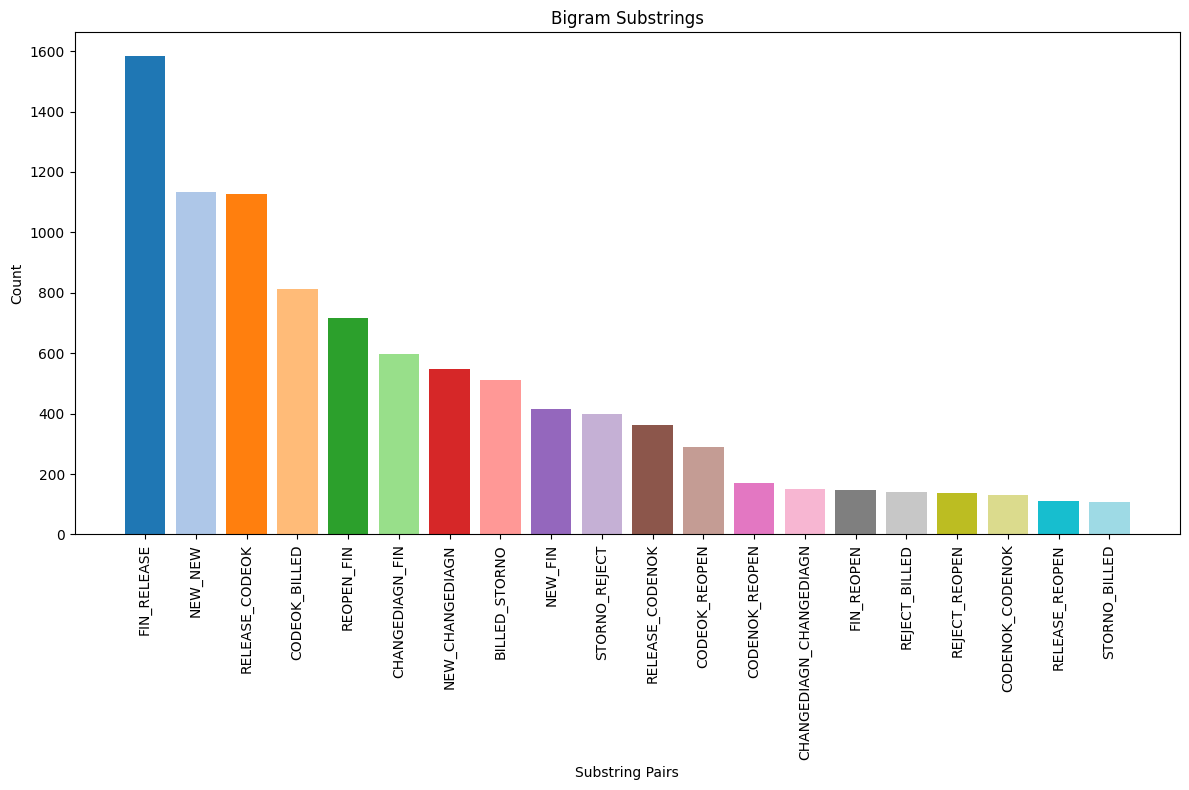

In [12]:


import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
# Function to split strings by spaces with the  separator being ' ' 
def split_by_backspace_separator(s):
    return s.split()

# Count the occurrences of each substring pair
substring_counter = Counter()

single_elements_counter = Counter()

for item in traces:
    substrings = split_by_backspace_separator(item)
    
    if len(substrings) == 0 or (len(substrings) == 1 and substrings[0] == ''):
        single_elements_counter[''] += 1
    else:
        for i in range(len(substrings) - 1):
            pair = f"{substrings[i]}_{substrings[i+1]}"
           
            substring_counter[pair] += 1
        if len(substrings) == 1 and substrings[0] != '':
            single_elements_counter[substrings[0]] += 1


# For including the length 1 or the length 2 itemsets:
#total_counter = substring_counter.update( single_elements_counter)


total_counter = substring_counter 
# Sort the pairs by their count
sorted_pairs = sorted(substring_counter.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_pairs)

# Generate a list of colors
colors = plt.cm.tab20(np.linspace(0, 1, len(labels[0:20])))
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(labels[0:20], values[0:20],color=colors)
plt.xlabel('Substring Pairs')
plt.ylabel('Count')
plt.title('Bigram Substrings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

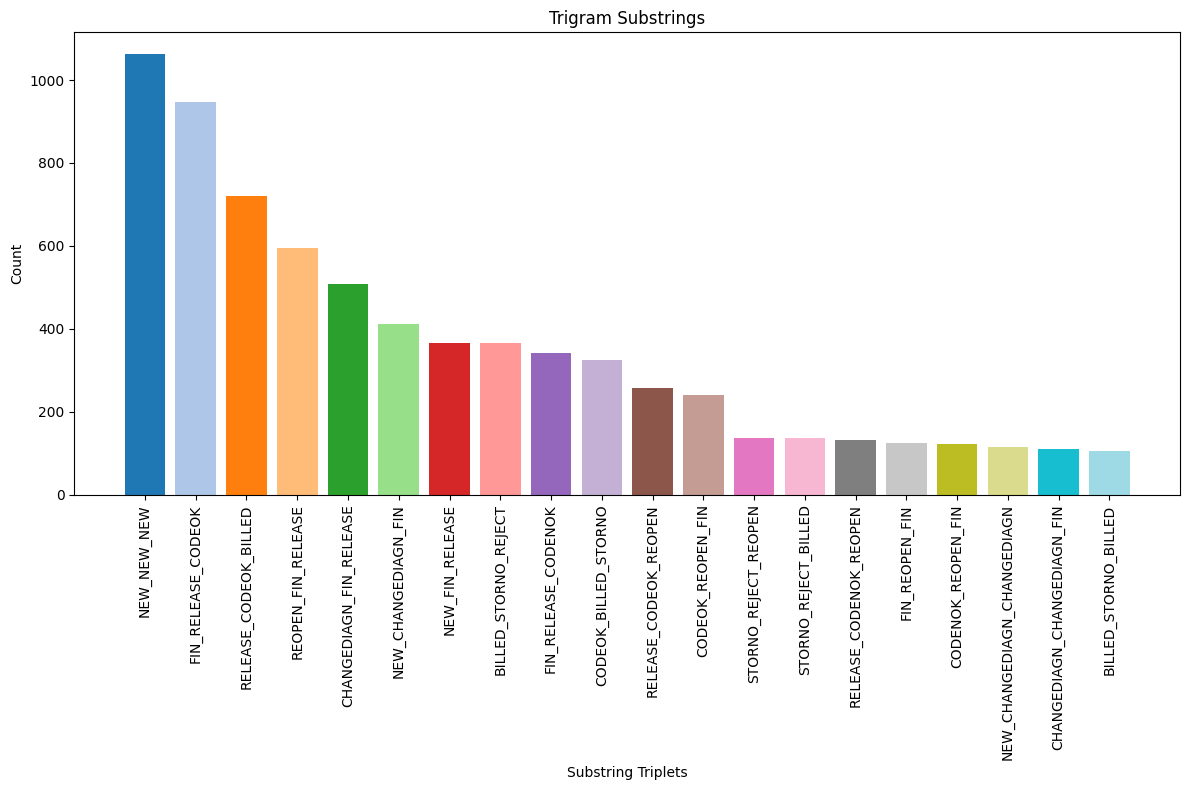

In [13]:


import matplotlib.pyplot as plt
from collections import Counter
# Function to split strings by spaces with the  separator being ' ' 
def split_by_backspace_separator(s):
    return s.split()

# Count the occurrences of each substring pair
substring_counter = Counter()

single_elements_counter = Counter()
#double_elements_counter = Counter()
for item in traces:
    substrings = split_by_backspace_separator(item)
    
    if len(substrings) == 0 or (len(substrings) == 1 and substrings[0] == ''):
        single_elements_counter[''] += 1
    else:
        for i in range(len(substrings) - 2):
            pair = f"{substrings[i]}_{substrings[i+1]}_{substrings[i+2]}"
            
            substring_counter[pair] += 1
       
        if len(substrings) == 1 and substrings[0] != '':
            single_elements_counter[substrings[0]] += 1


total_counter = substring_counter 
# Sort the pairs by their count
sorted_triplets = sorted(substring_counter.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_triplets)
colors = plt.cm.tab20(np.linspace(0, 1, len(labels[0:20])))
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(labels[0:20], values[0:20], color = colors)
plt.xlabel('Substring Triplets')
plt.ylabel('Count')
plt.title('Trigram Substrings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Evaluation of the bi-grams and tri-grams using DBSCAN:

In [14]:

from sklearn.cluster import DBSCAN
import numpy as np



for eps in [0.05]:  #[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]    
    
    

    dbscan = DBSCAN(eps=eps, n_jobs=-1, min_samples=2)
   
    
    labels= dbscan.fit_predict(bi_gram)
    
    
    df['Cluster'] = dbscan.labels_
    df_sorted = df.sort_values(by='Cluster')

    

    cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
    for cluster_id, size in cluster_sizes.items():
        print(f"Cluster {cluster_id}: {size} Traces")

    
    #df_sorted.to_csv('small_testing.csv', index=False)




Cluster -1: 934 Traces
Cluster 0: 2 Traces
Cluster 1: 2 Traces
Cluster 2: 2 Traces
Cluster 3: 2 Traces
Cluster 4: 2 Traces
Cluster 5: 2 Traces
Cluster 6: 2 Traces
Cluster 7: 2 Traces
Cluster 8: 2 Traces
Cluster 9: 2 Traces
Cluster 10: 2 Traces
Cluster 11: 2 Traces
Cluster 12: 2 Traces
Cluster 13: 2 Traces
Cluster 14: 2 Traces
Cluster 15: 2 Traces
Cluster 16: 2 Traces
Cluster 17: 2 Traces
Cluster 18: 2 Traces
Cluster 19: 2 Traces
Cluster 20: 2 Traces
Cluster 21: 2 Traces
Cluster 22: 2 Traces
Cluster 23: 2 Traces
Cluster 24: 2 Traces
Cluster 25: 2 Traces
Cluster 26: 2 Traces
Cluster 27: 2 Traces
Cluster 28: 2 Traces
Cluster 29: 2 Traces
Cluster 30: 2 Traces
Cluster 31: 2 Traces
Cluster 32: 2 Traces
Cluster 33: 2 Traces
Cluster 34: 2 Traces
Cluster 35: 2 Traces
Cluster 36: 2 Traces
Cluster 37: 2 Traces
Cluster 38: 2 Traces
Cluster 39: 2 Traces
Cluster 40: 2 Traces
Cluster 41: 2 Traces
Cluster 42: 2 Traces


Bi-gram Interpretation and Visualization:

Silhouette Coefficient AVG: -0.38841253358761124
Silhouette Coefficient for cluster 0: 1.0
Silhouette Coefficient for cluster 1: 1.0
Silhouette Coefficient for cluster 2: 1.0
Silhouette Coefficient for cluster 3: 1.0
Silhouette Coefficient for cluster 4: 1.0
Silhouette Coefficient for cluster 5: 1.0
Silhouette Coefficient for cluster 6: 1.0
Silhouette Coefficient for cluster 7: 1.0
Silhouette Coefficient for cluster 8: 1.0
Silhouette Coefficient for cluster 9: 1.0
Silhouette Coefficient for cluster 10: 1.0
Silhouette Coefficient for cluster 11: 1.0
Silhouette Coefficient for cluster 12: 1.0
Silhouette Coefficient for cluster 13: 1.0
Silhouette Coefficient for cluster 14: 1.0
Silhouette Coefficient for cluster 15: 1.0
Silhouette Coefficient for cluster 16: 1.0
Silhouette Coefficient for cluster 17: 1.0
Silhouette Coefficient for cluster 18: 1.0
Silhouette Coefficient for cluster 19: 1.0
Silhouette Coefficient for cluster 20: 1.0
Silhouette Coefficient for cluster 21: 1.0
Silhouette Coef

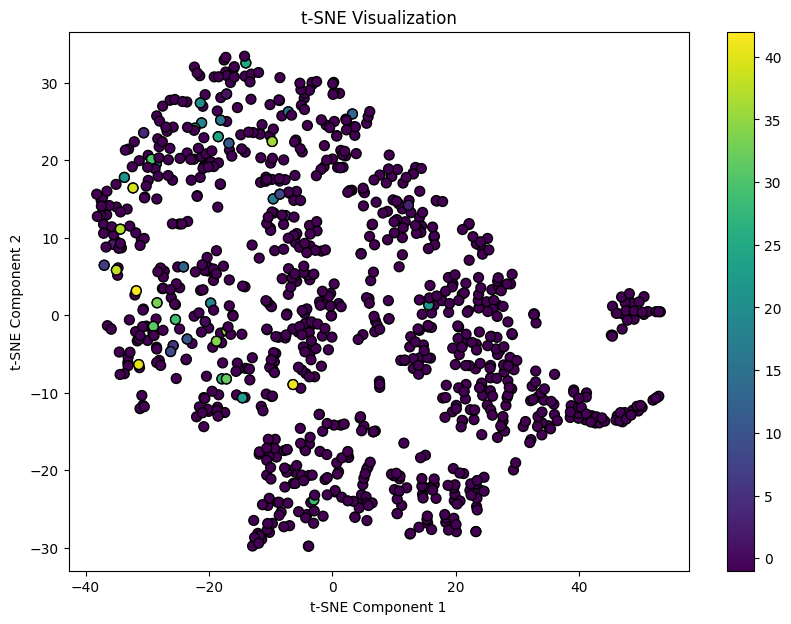

In [15]:
from sklearn.metrics import silhouette_score,silhouette_samples

if len(set(dbscan.labels_)) > 1:  
    silhouette_avg = silhouette_score(bi_gram, dbscan.labels_)
    print(f"Silhouette Coefficient AVG: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(bi_gram, dbscan.labels_)
    for i in range(len(set(dbscan.labels_)) - 1):  
        ith_cluster_silhouette_values = sample_silhouette_values[dbscan.labels_ == i]
        print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")
else:
    print("Only one cluster found. No Silhouette Coefficient.")




from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=30, n_iter=700)
tsne_result = tsne.fit_transform(bi_gram)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()



Bi-gram Petri nets


c:\Python312\Lib\site-packages\pm4py\utils.py:536: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


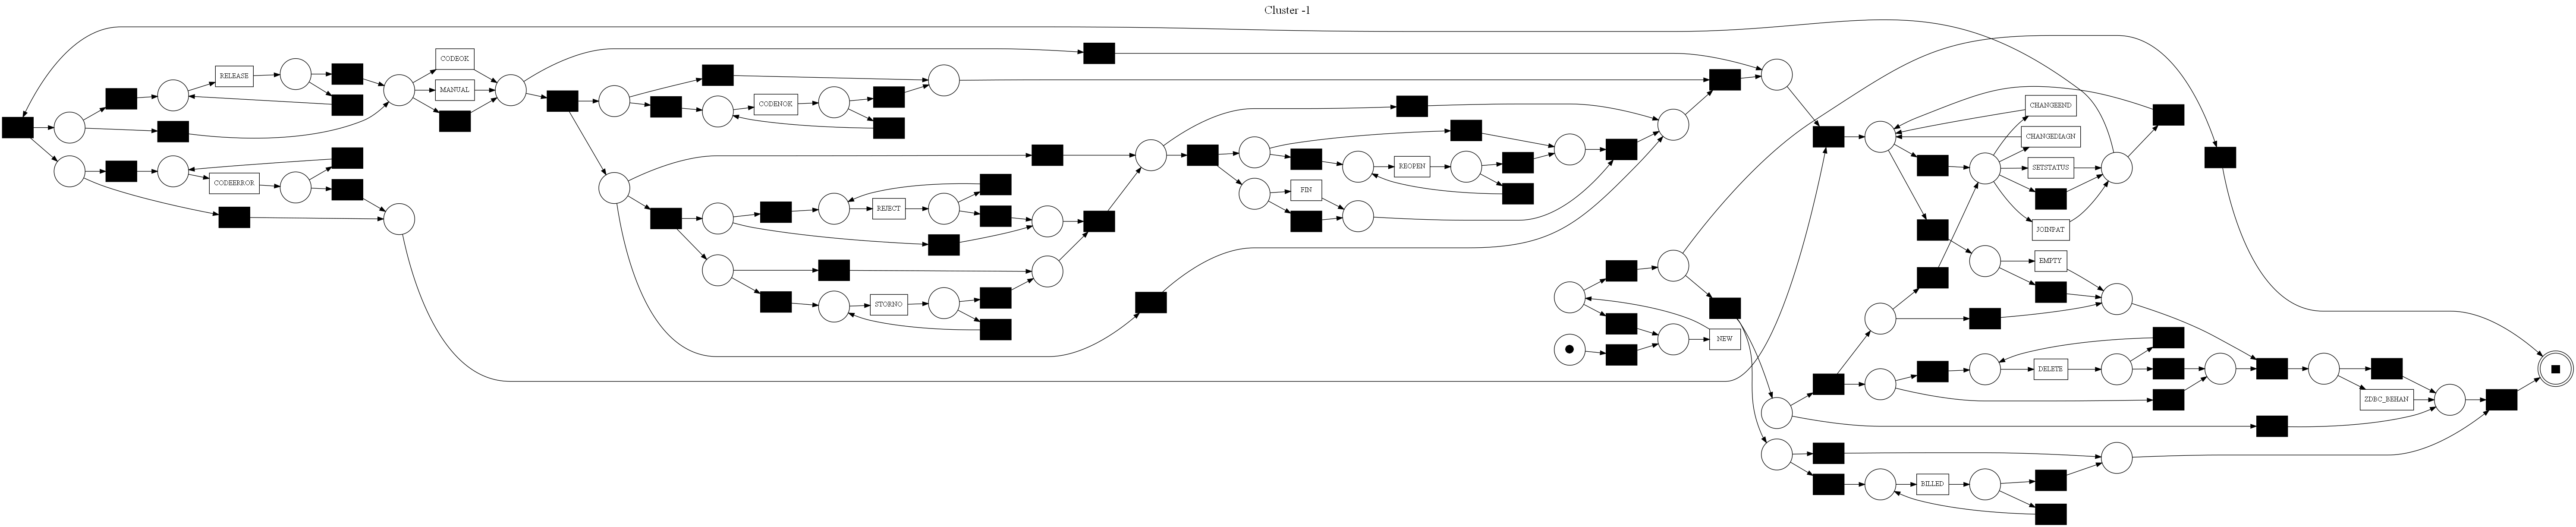

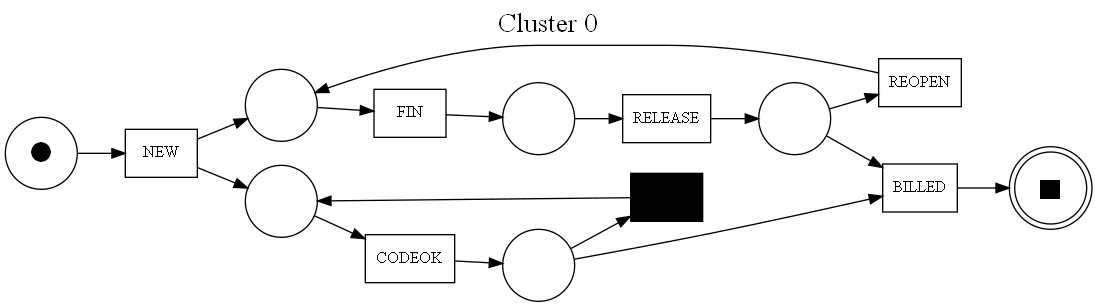

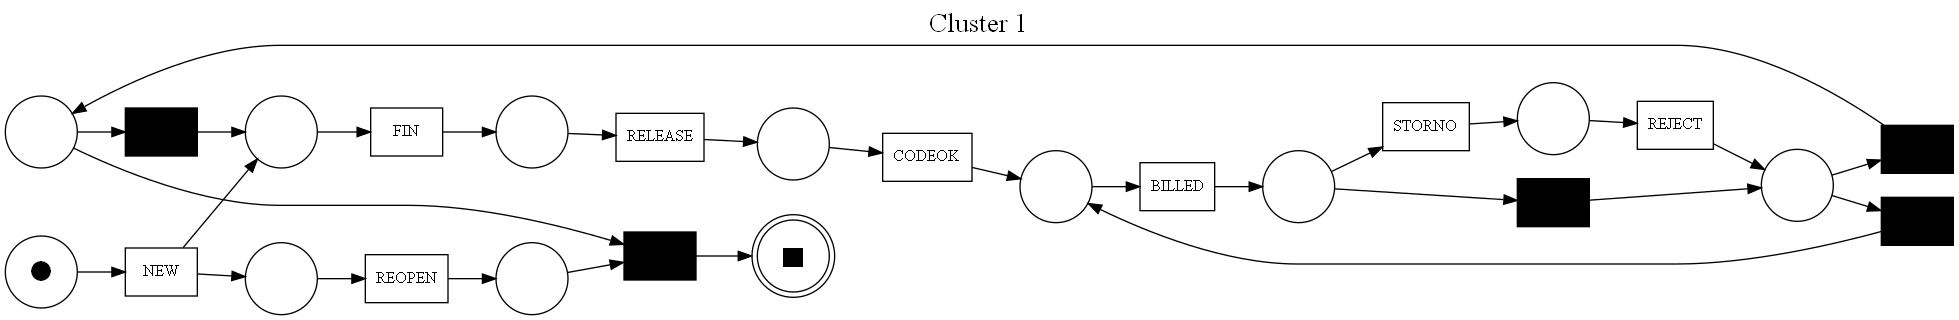

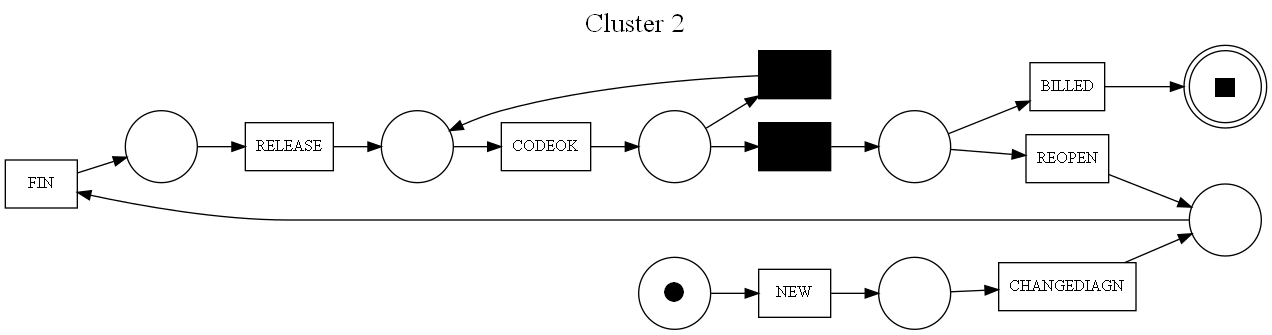

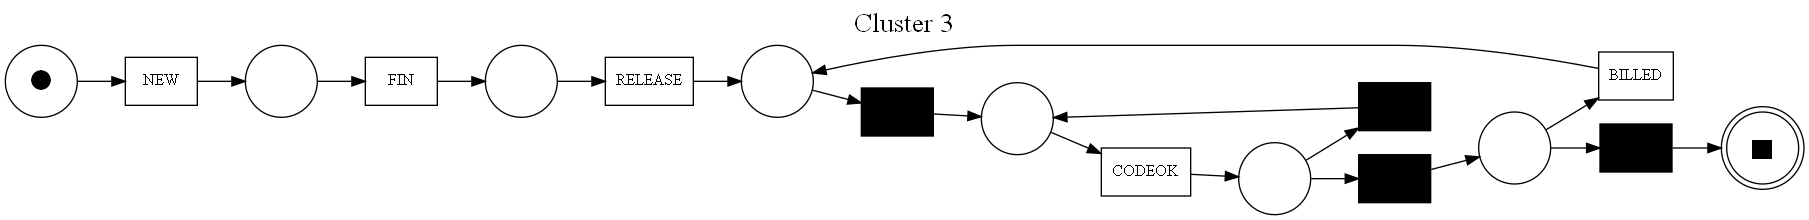

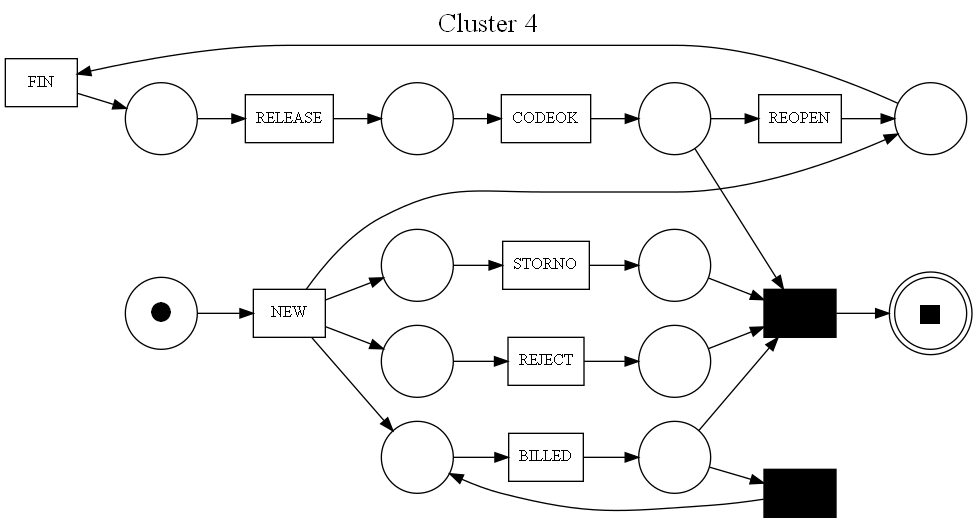

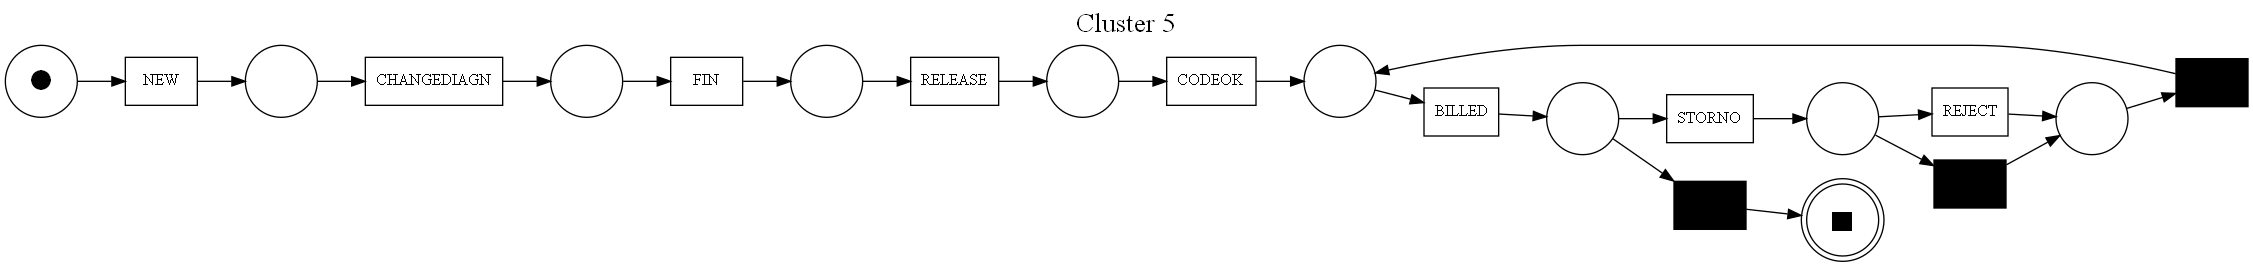

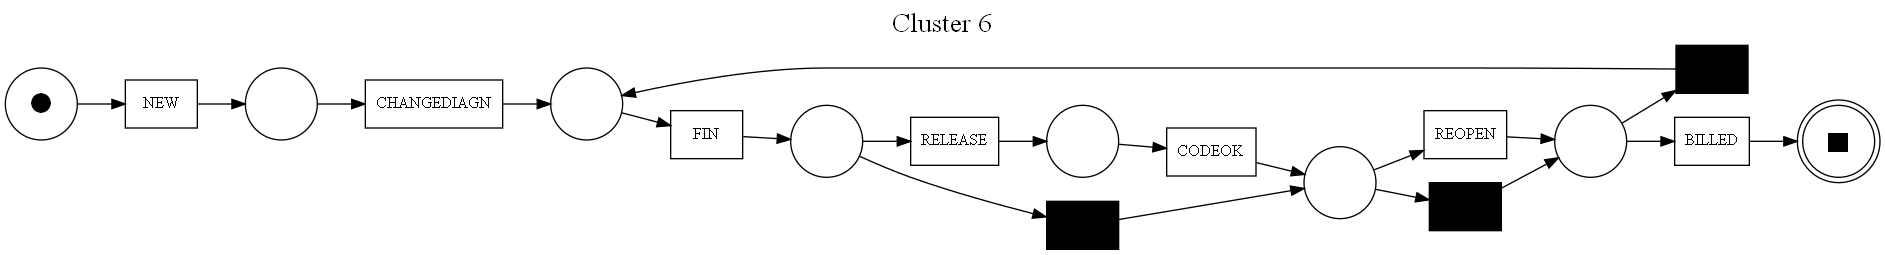

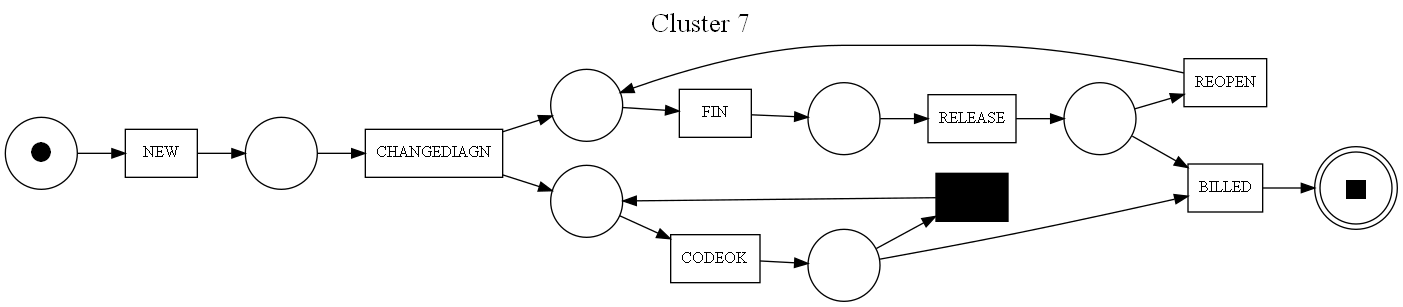

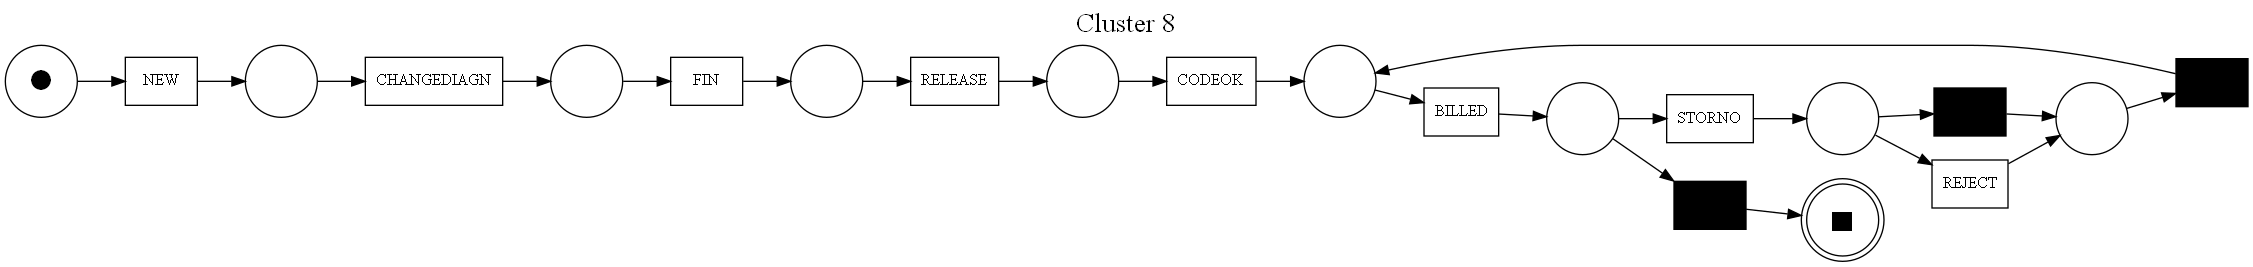

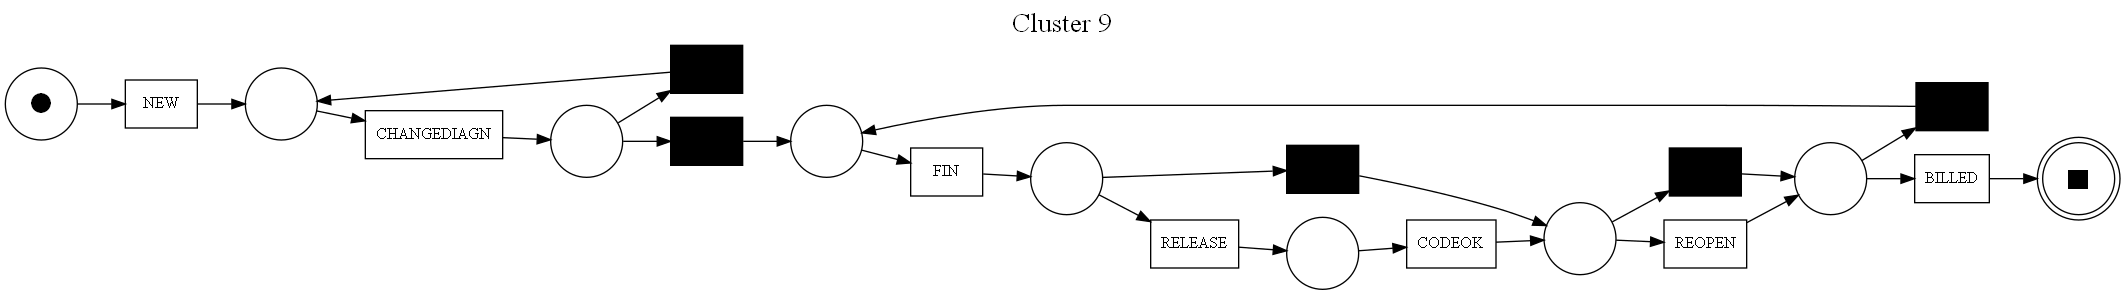

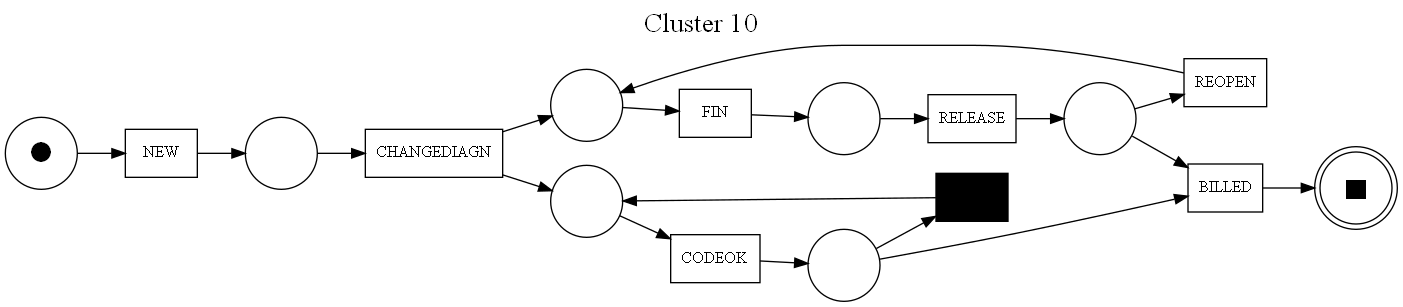

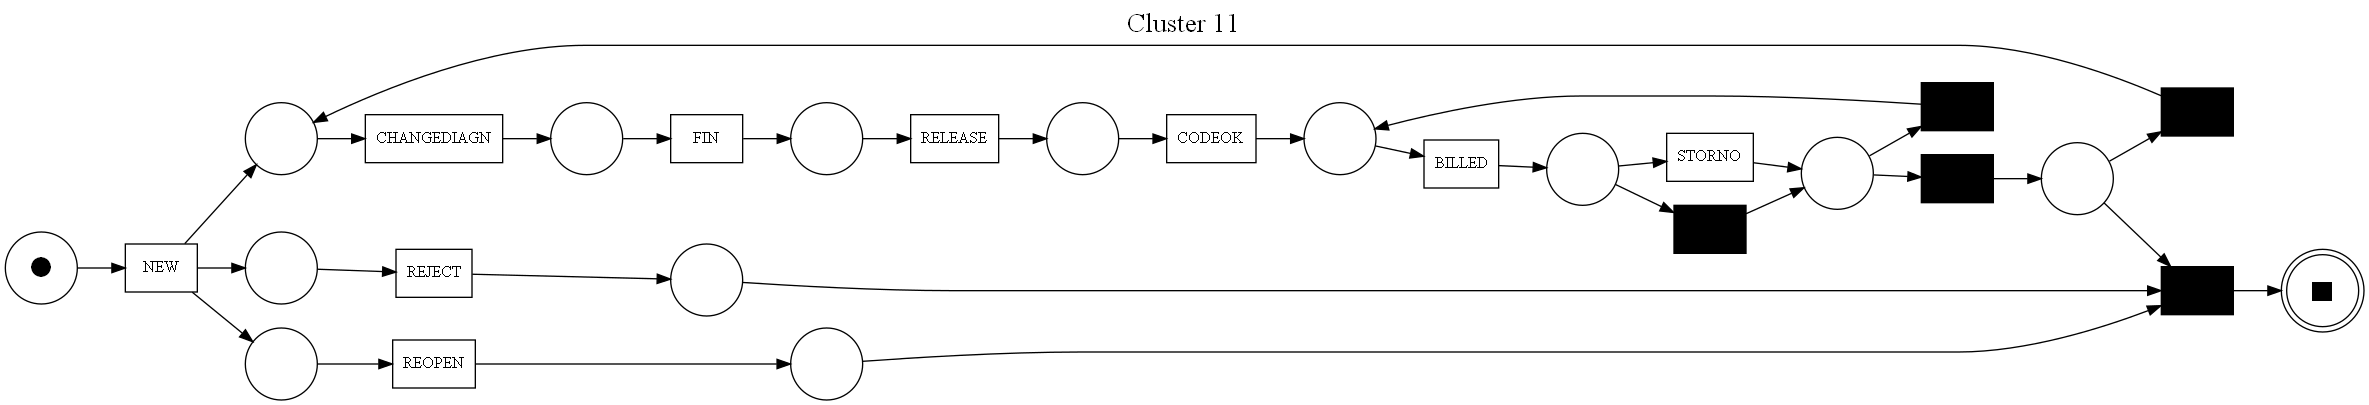

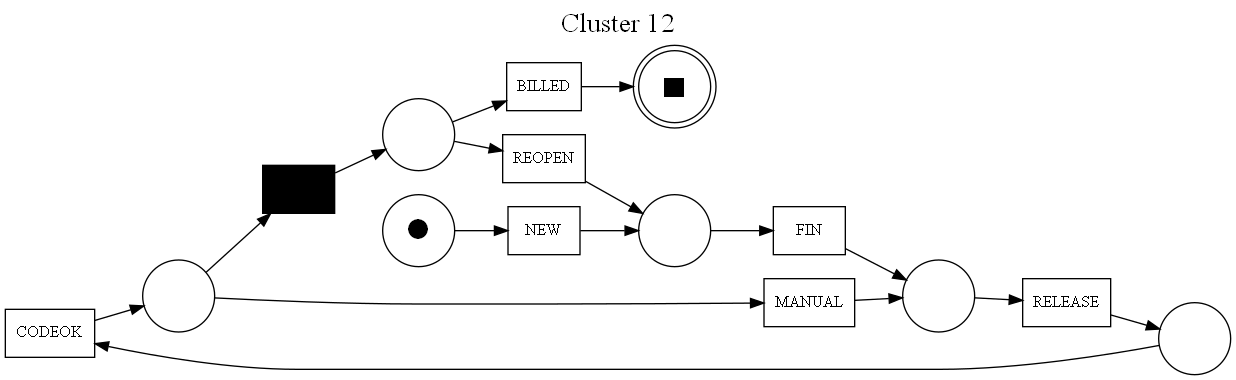

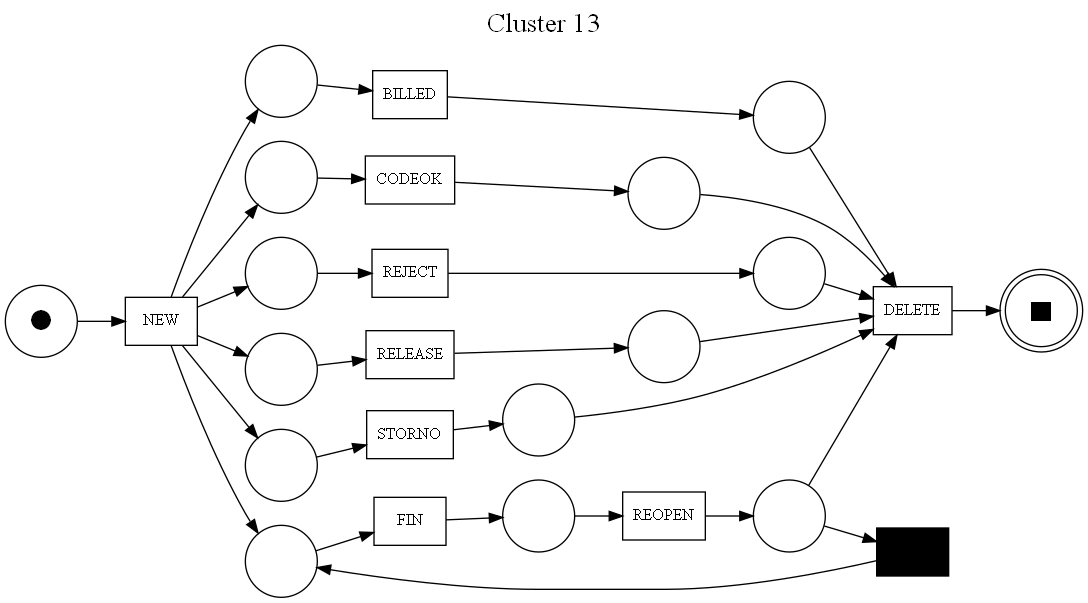

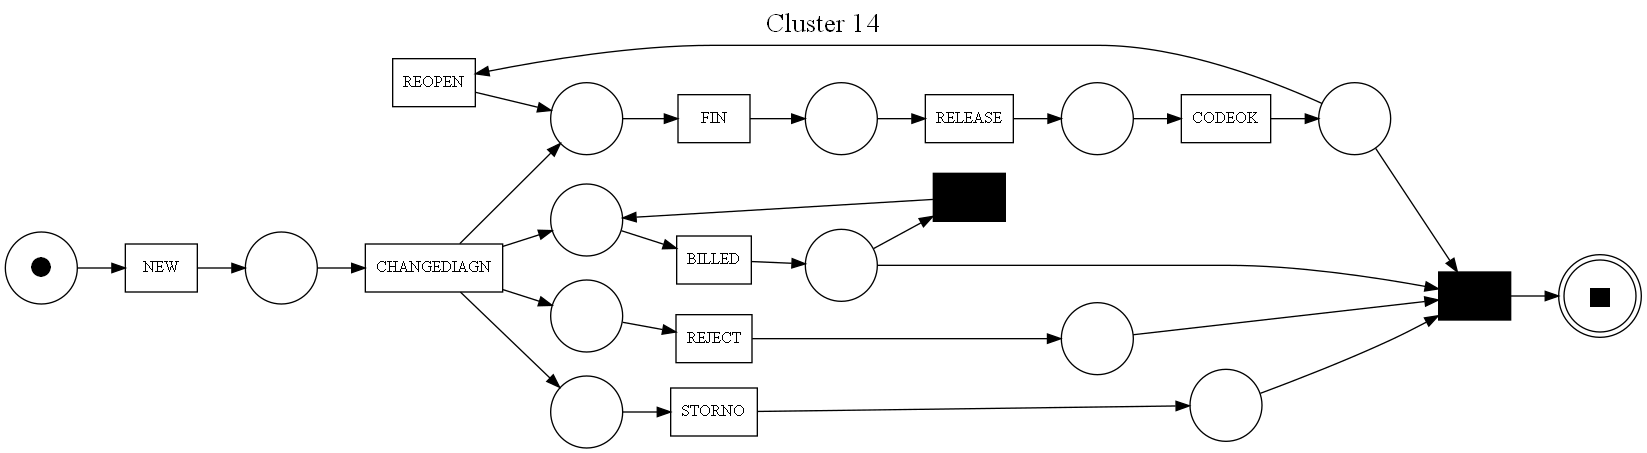

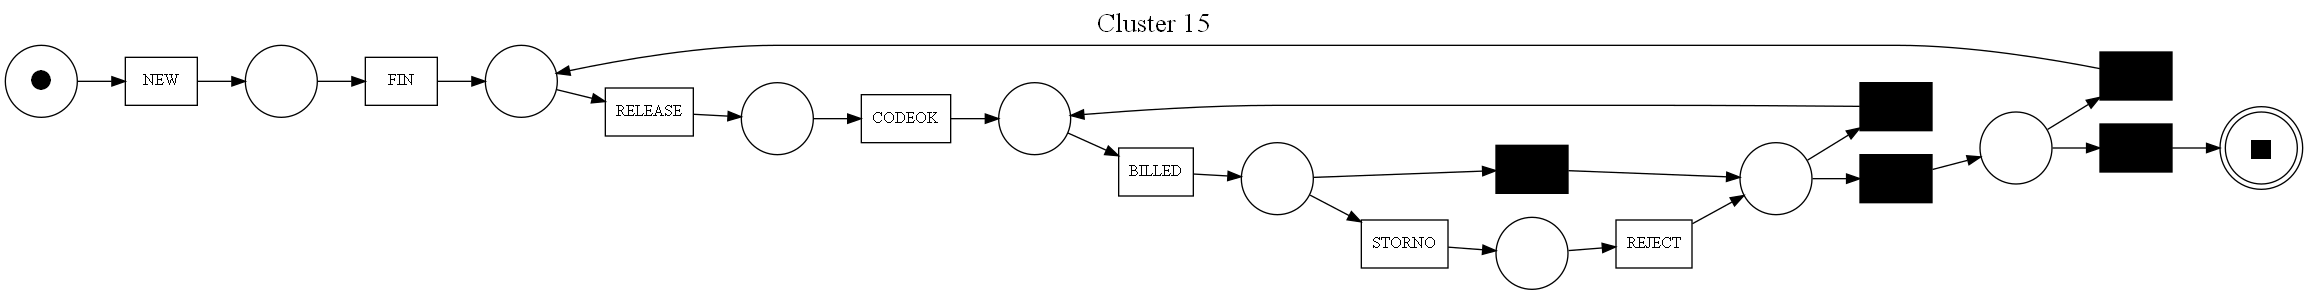

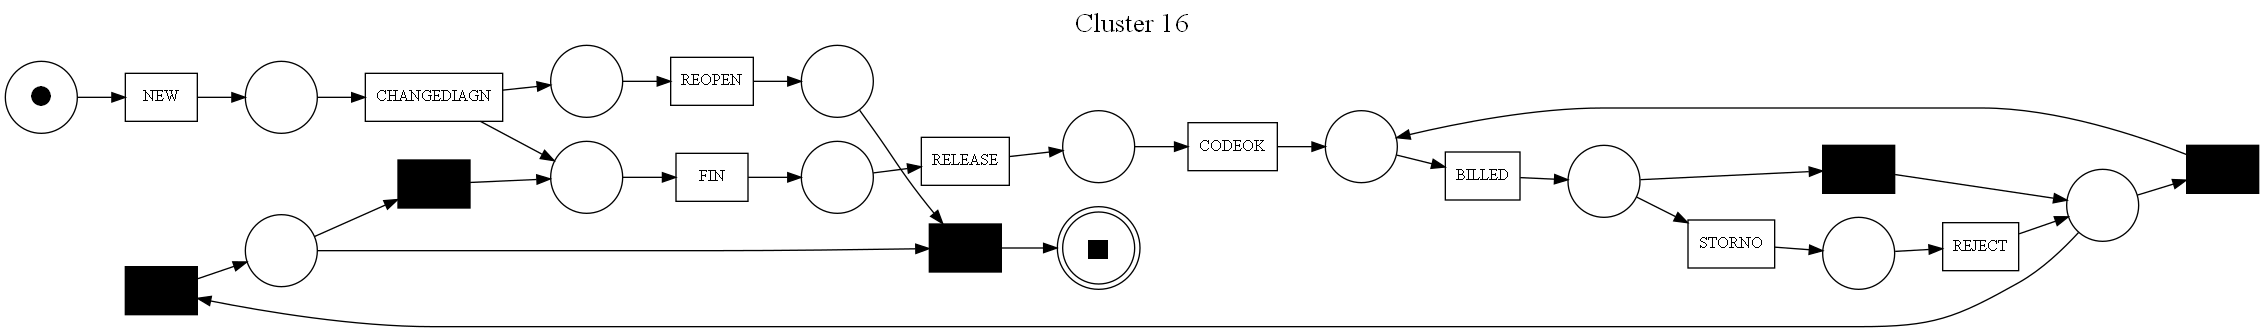

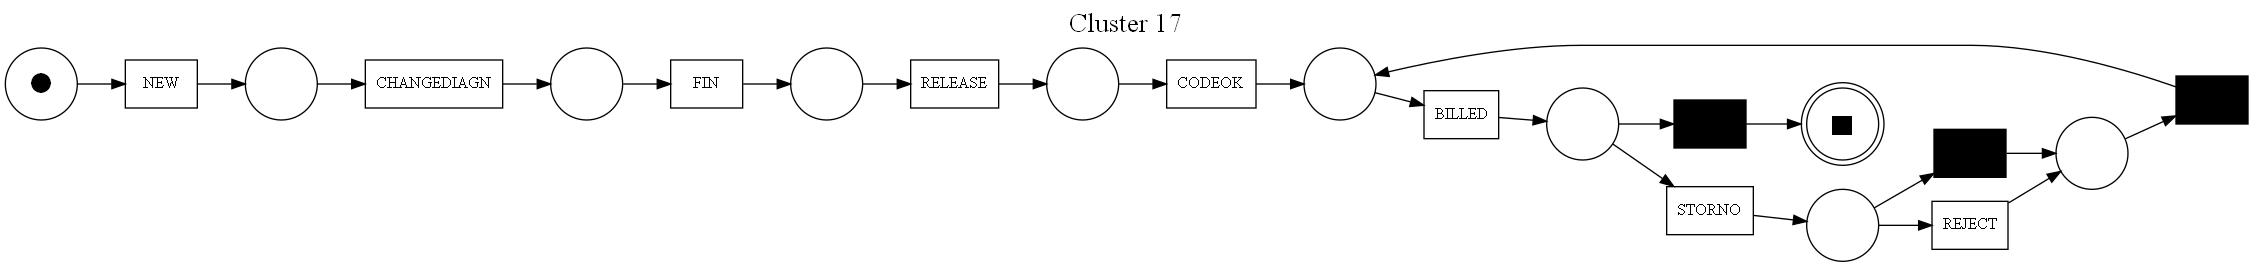

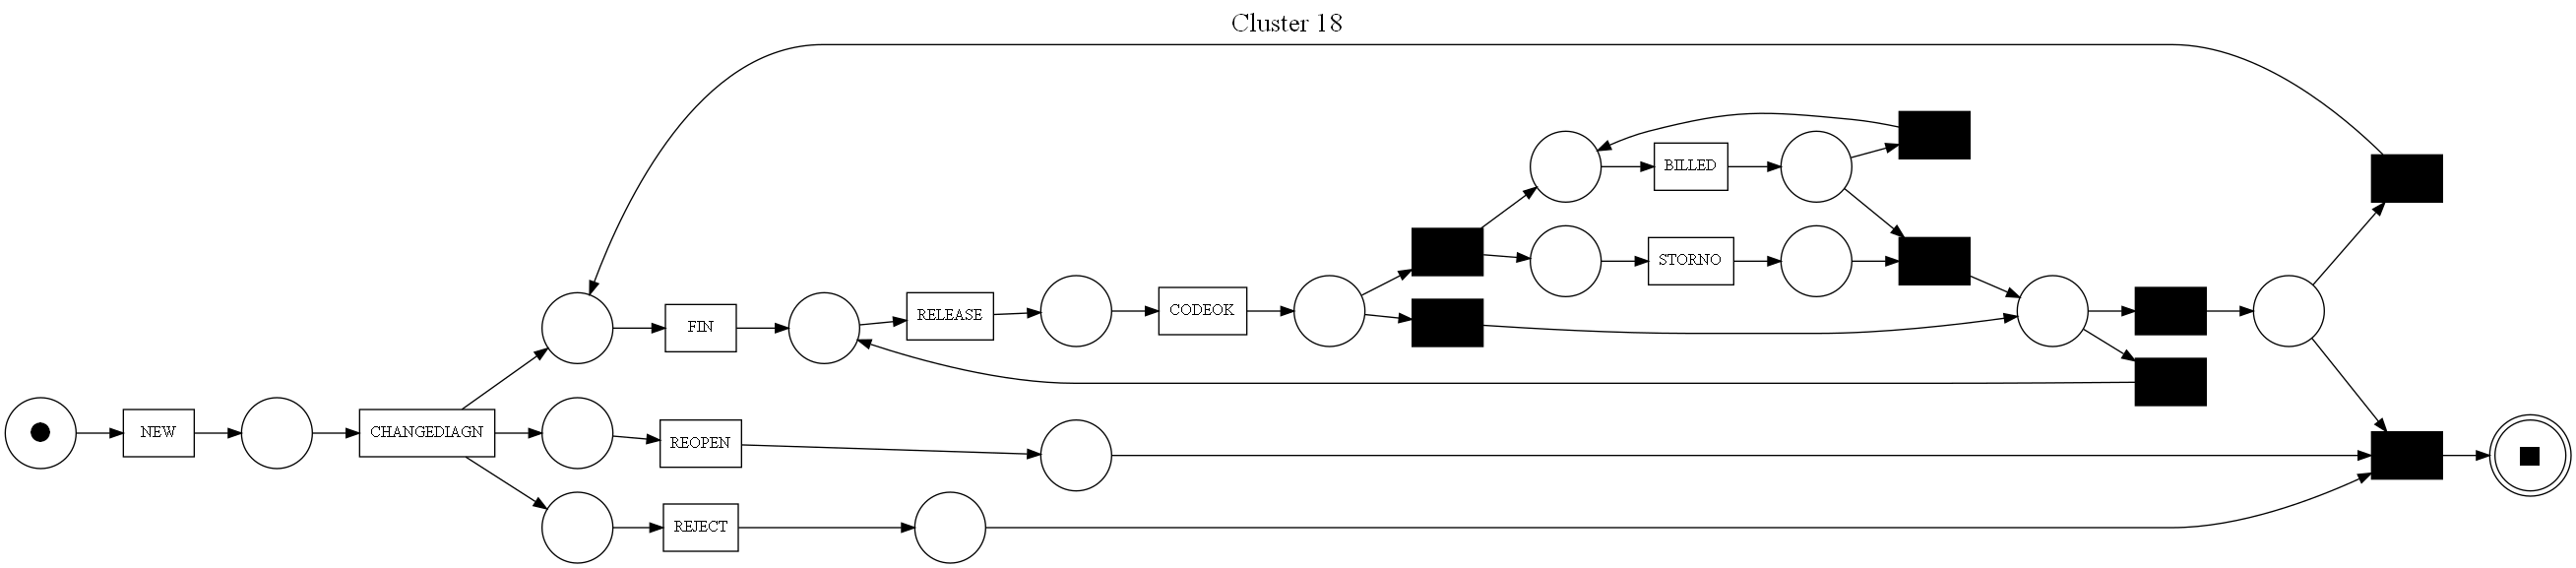

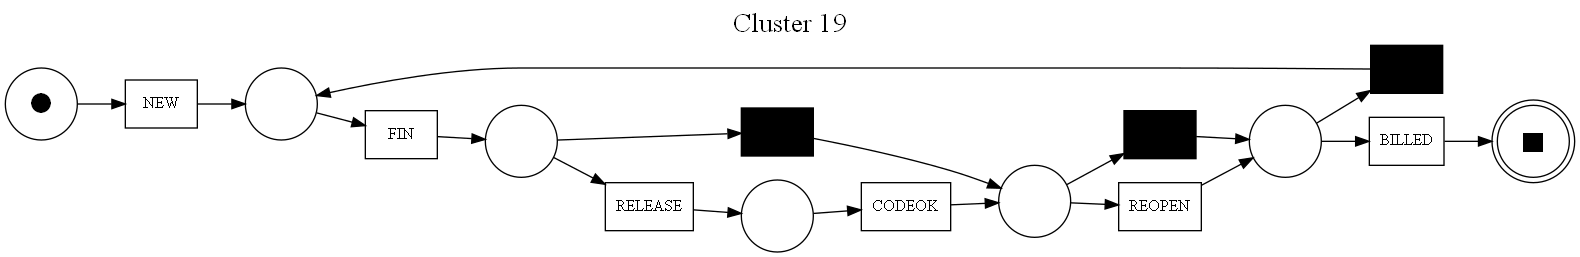

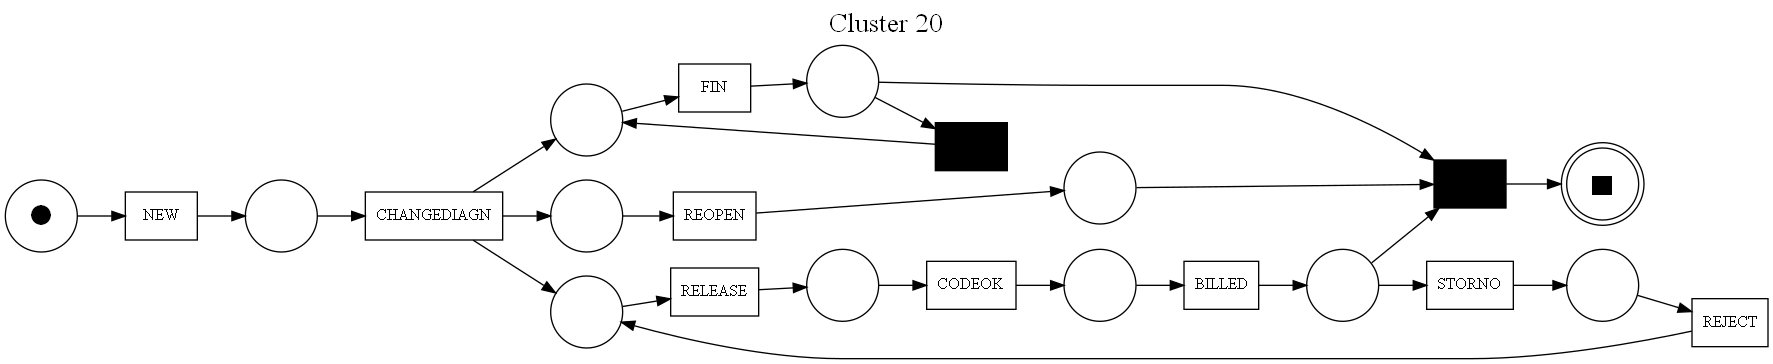

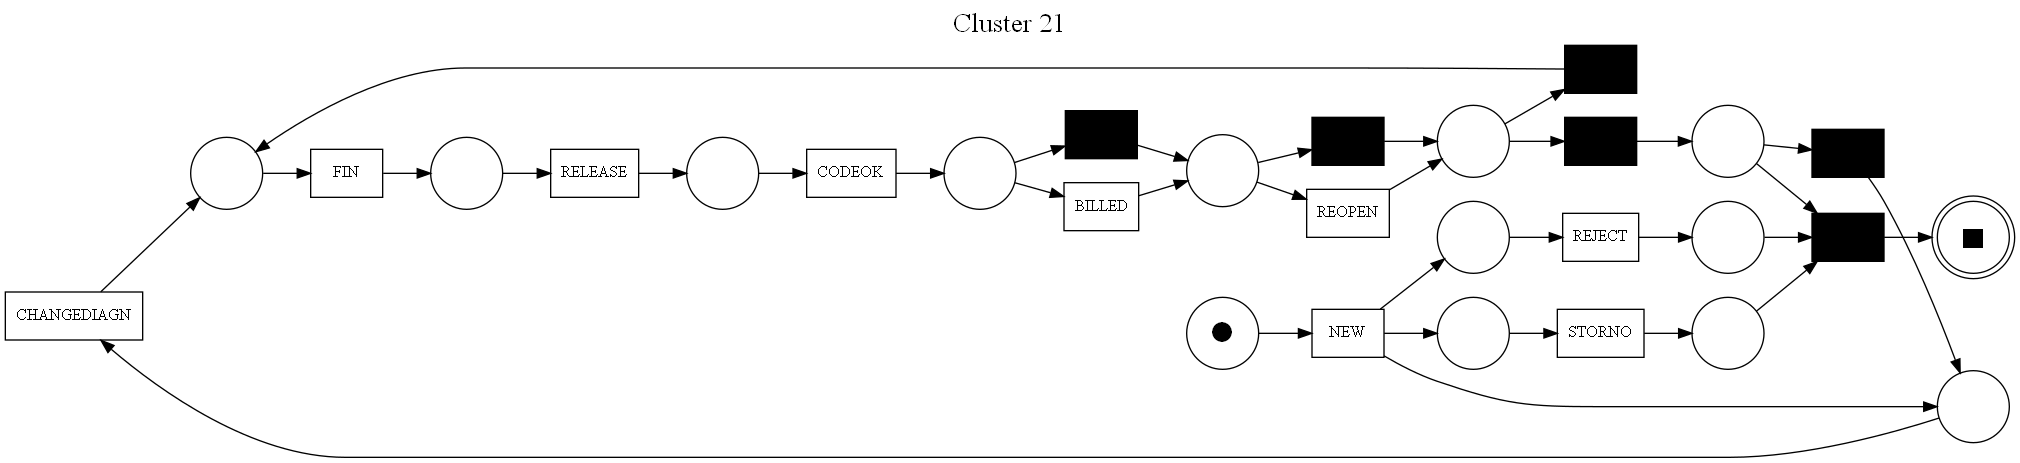

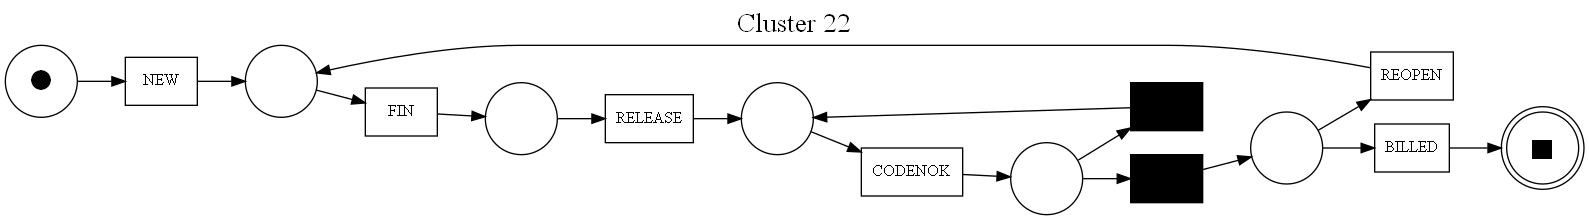

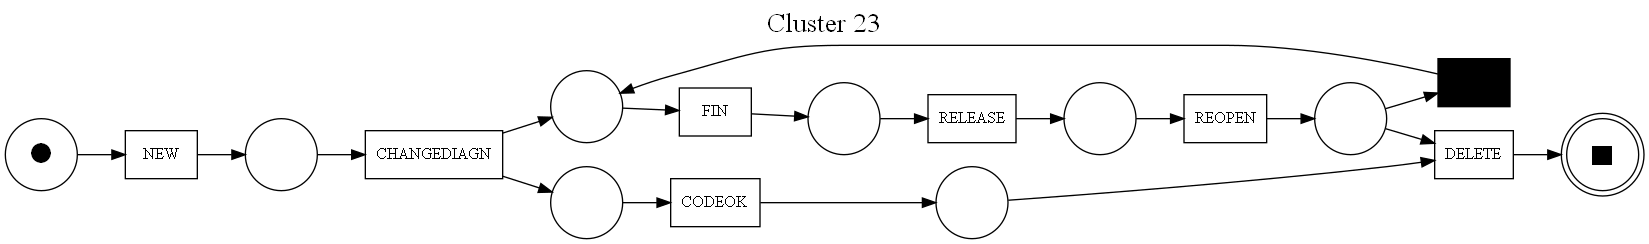

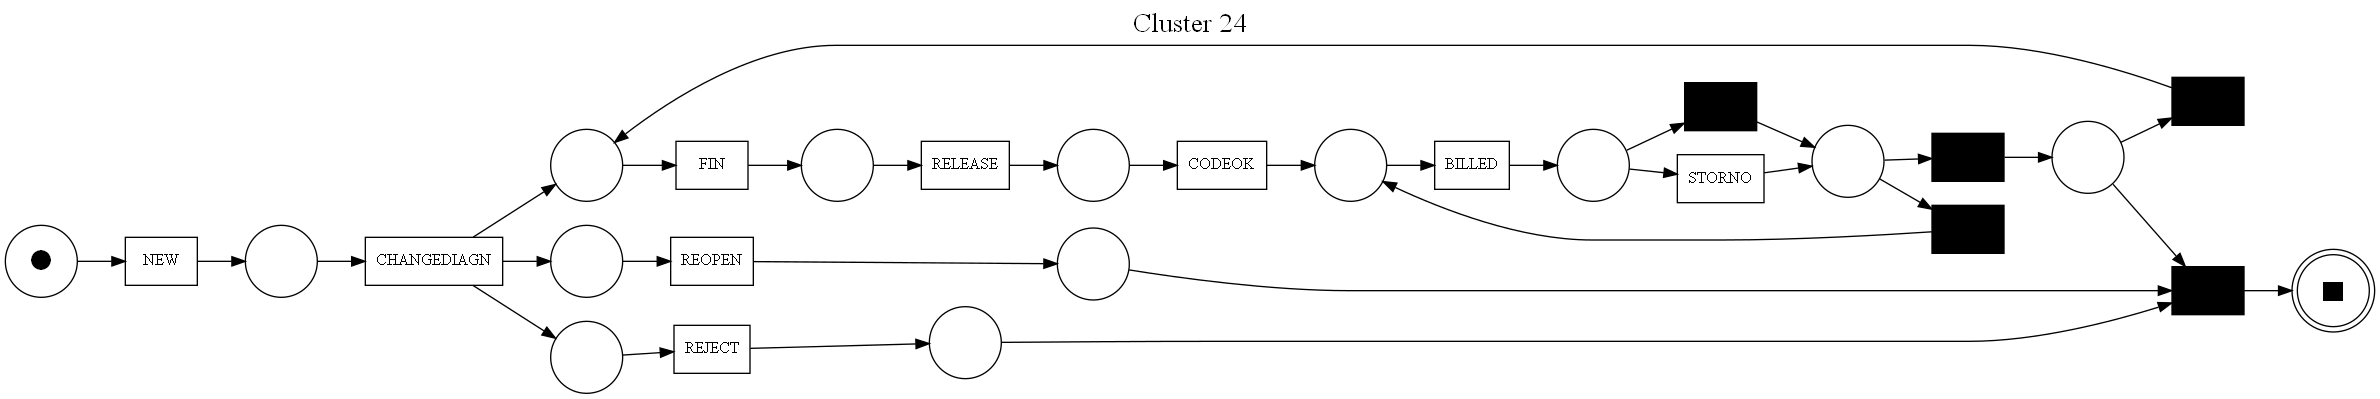

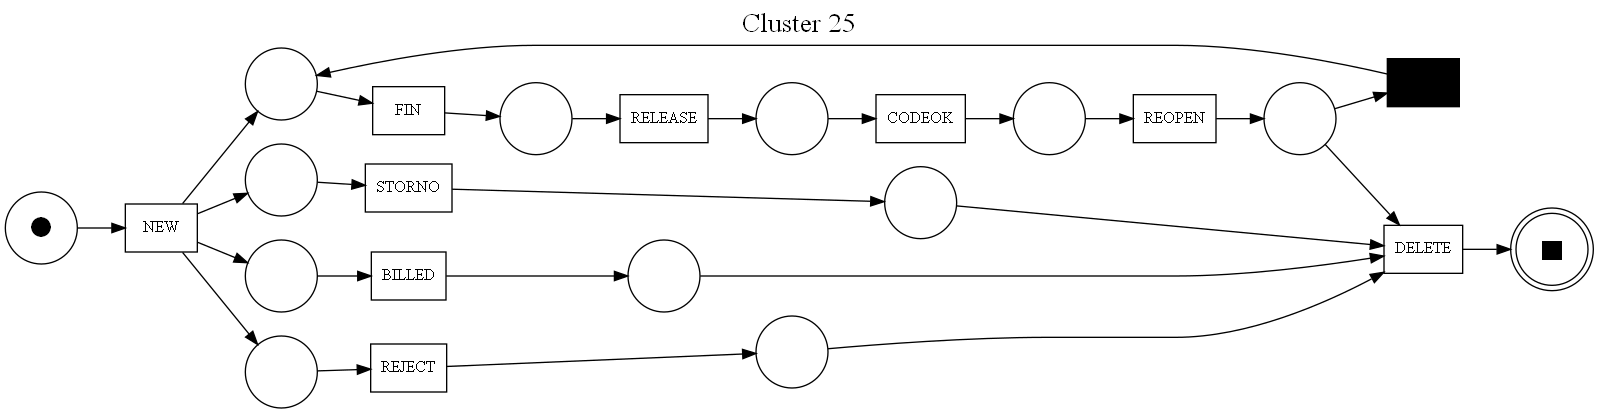

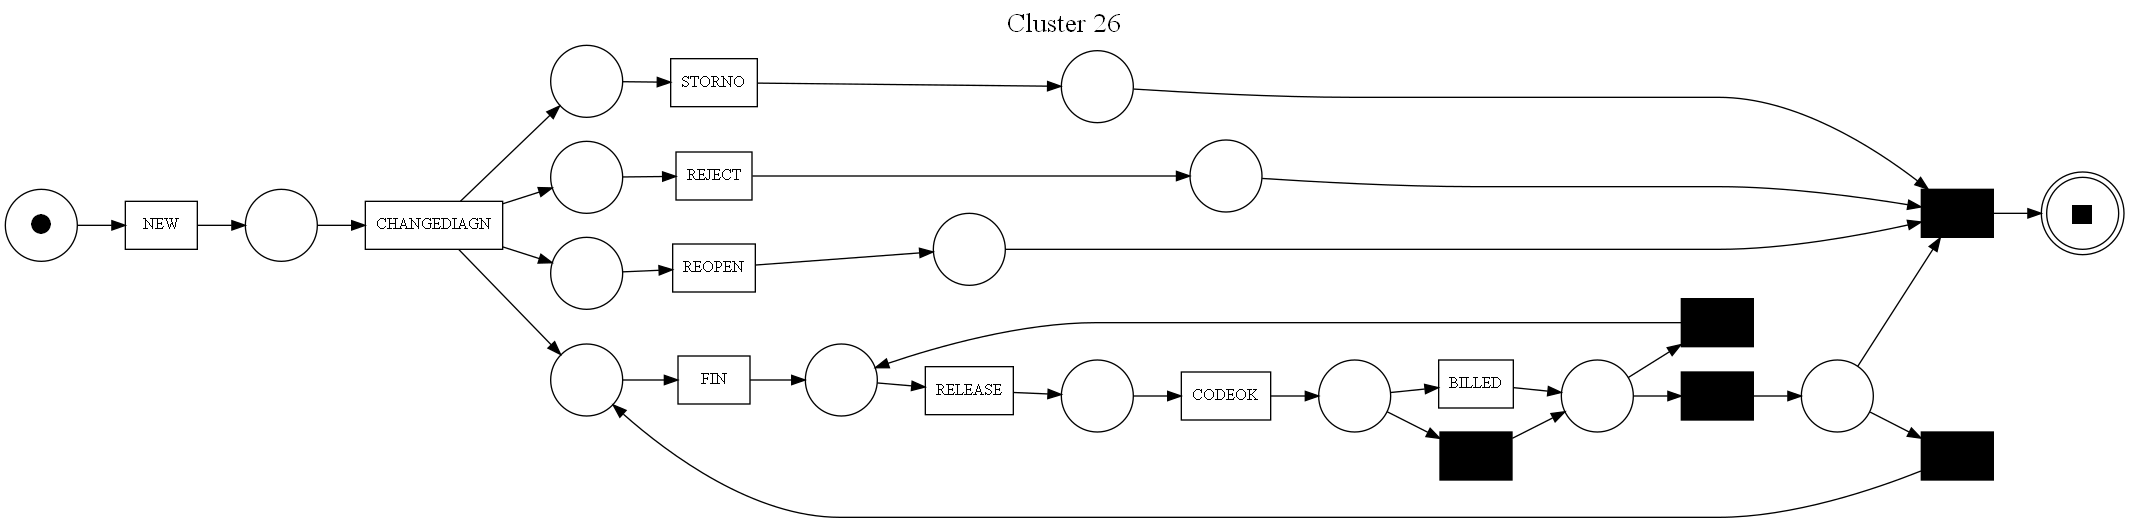

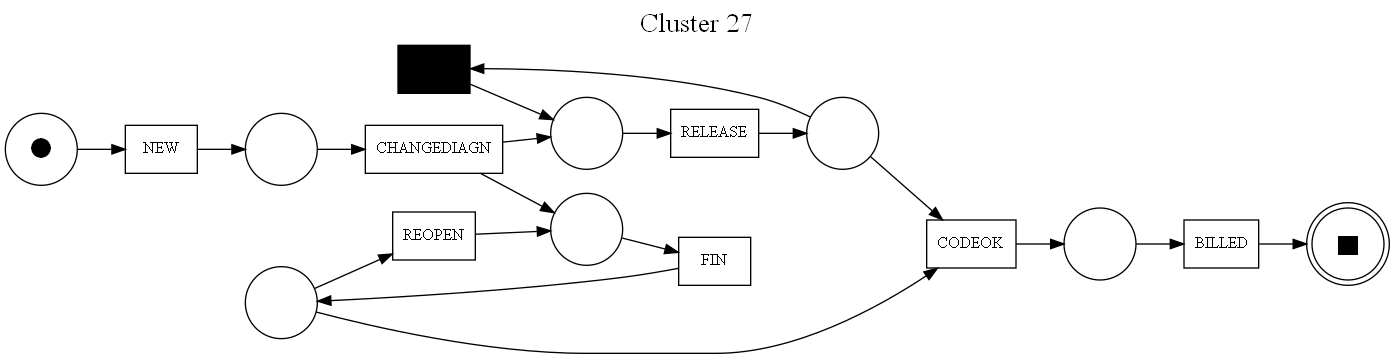

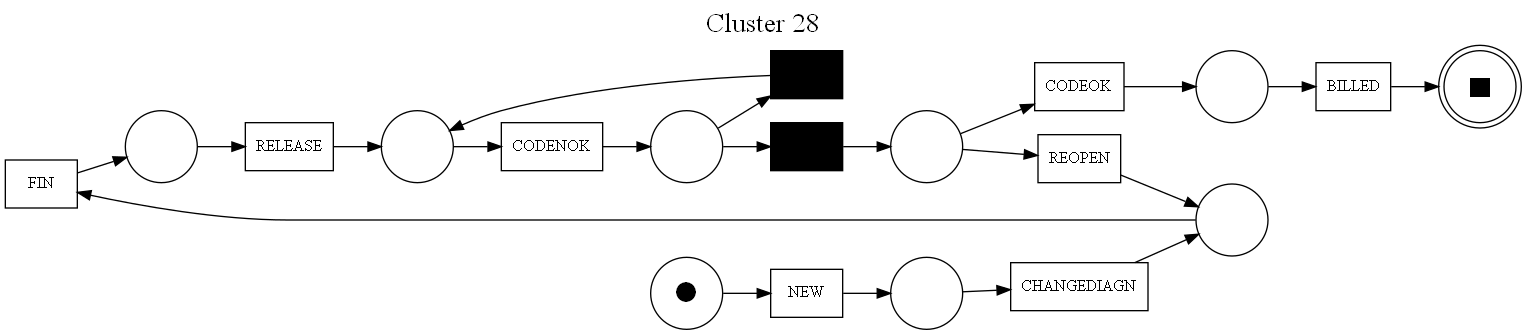

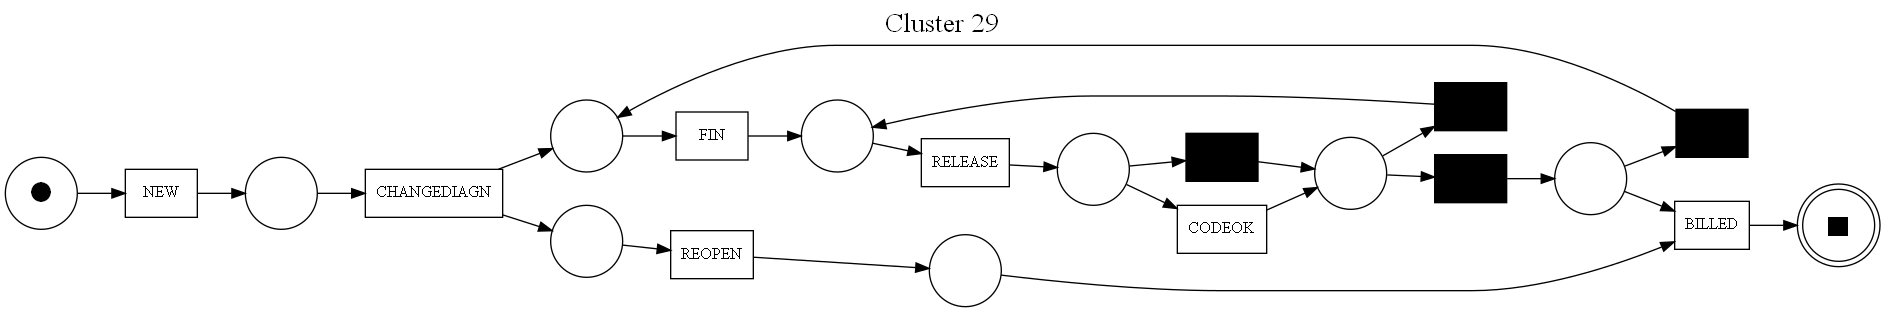

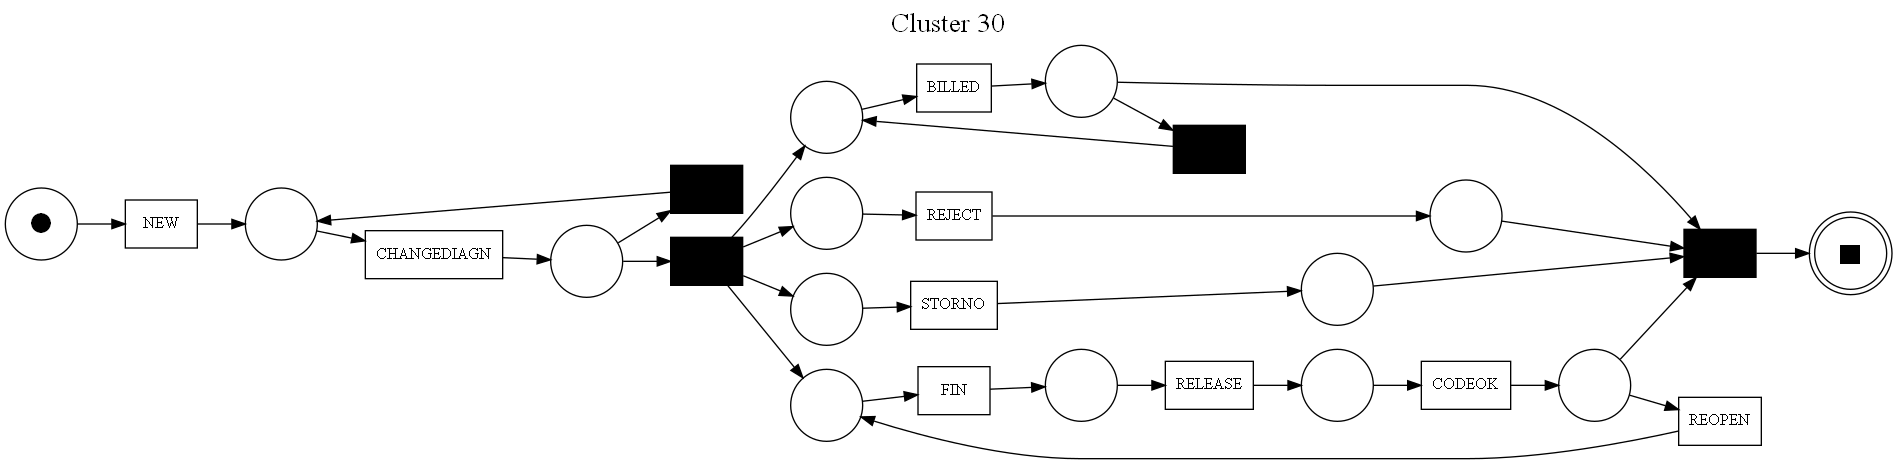

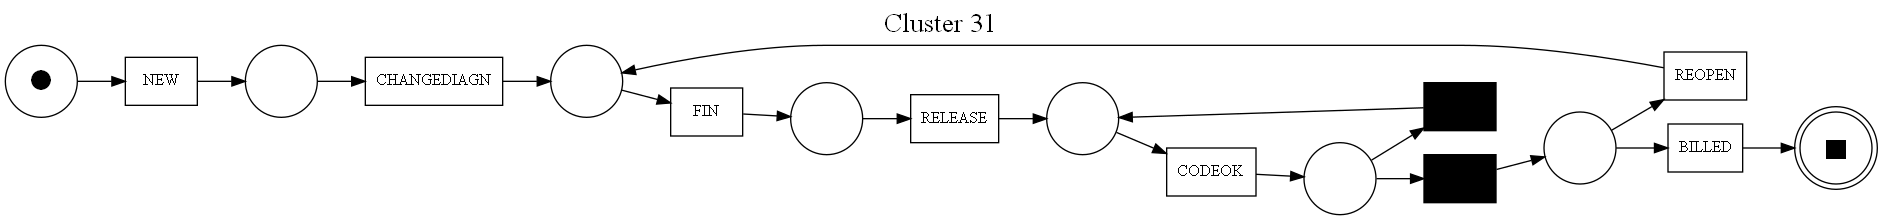

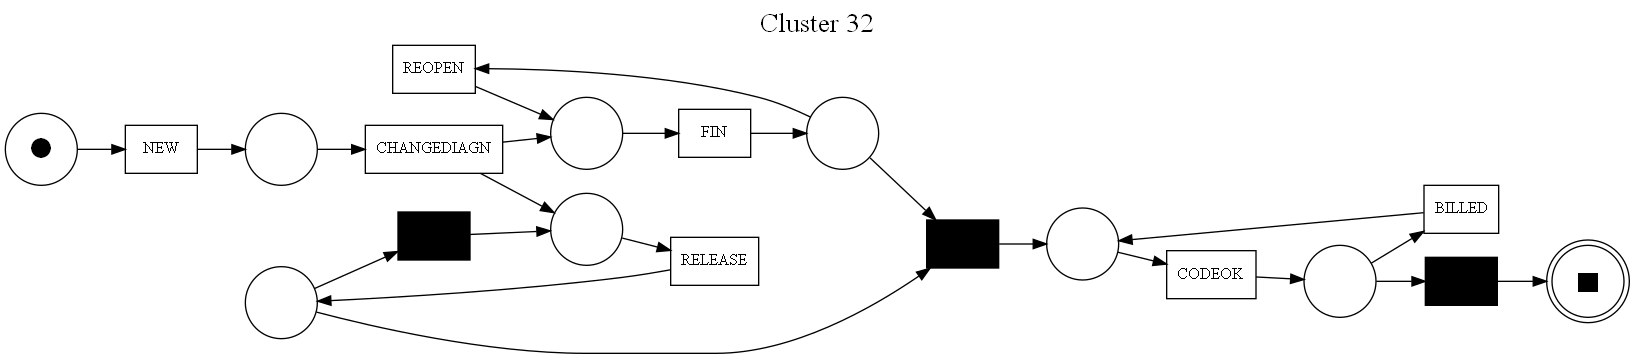

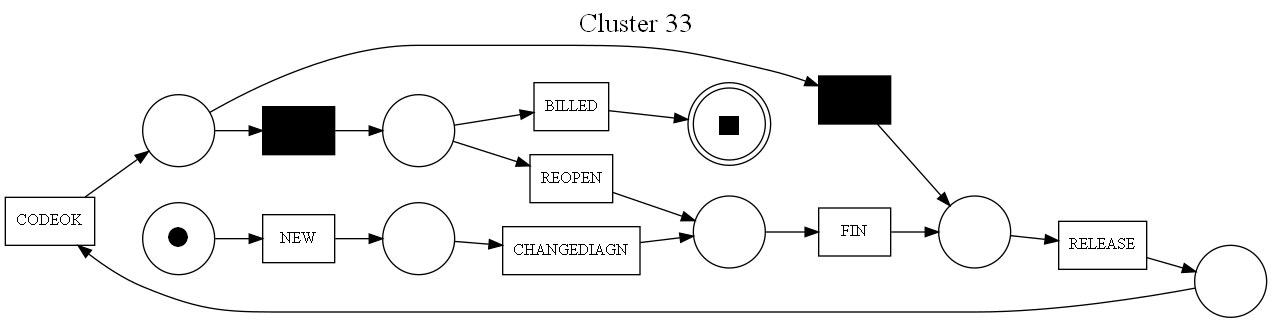

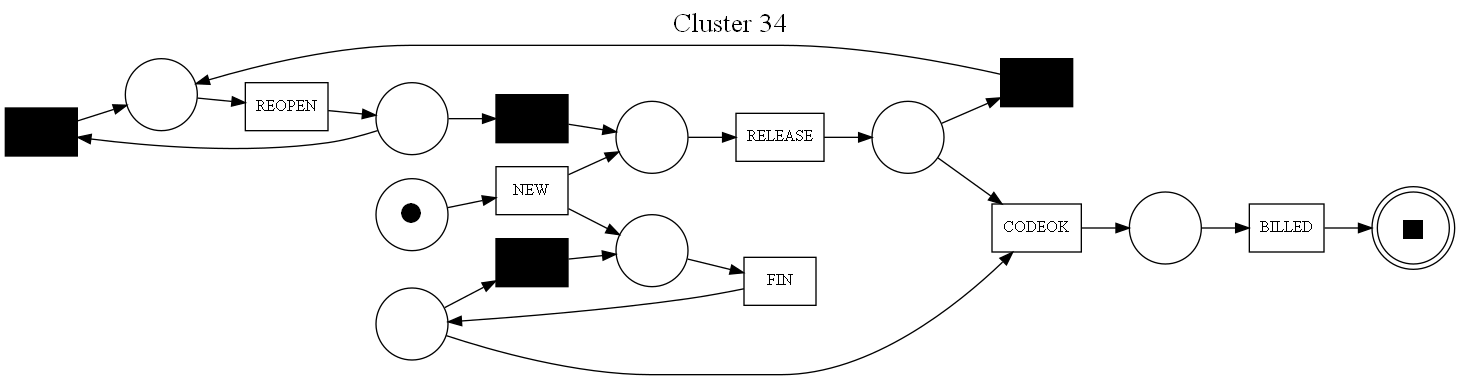

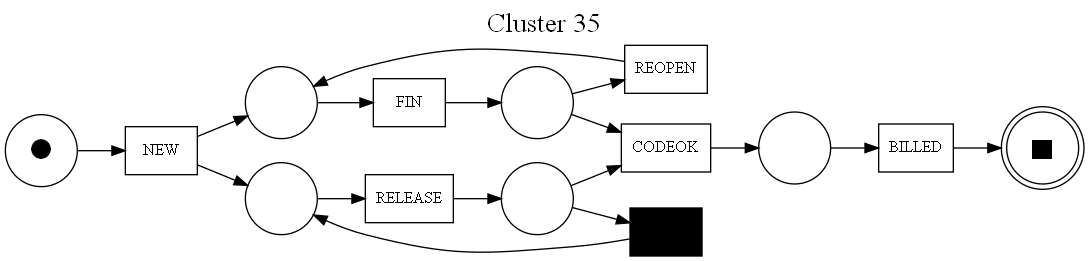

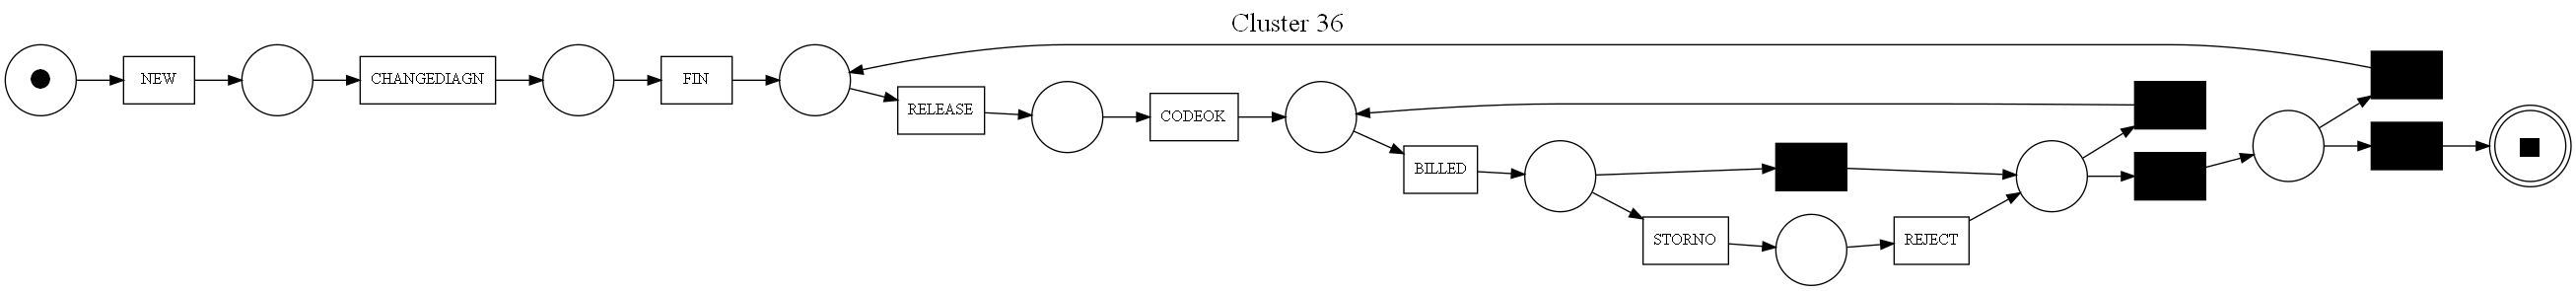

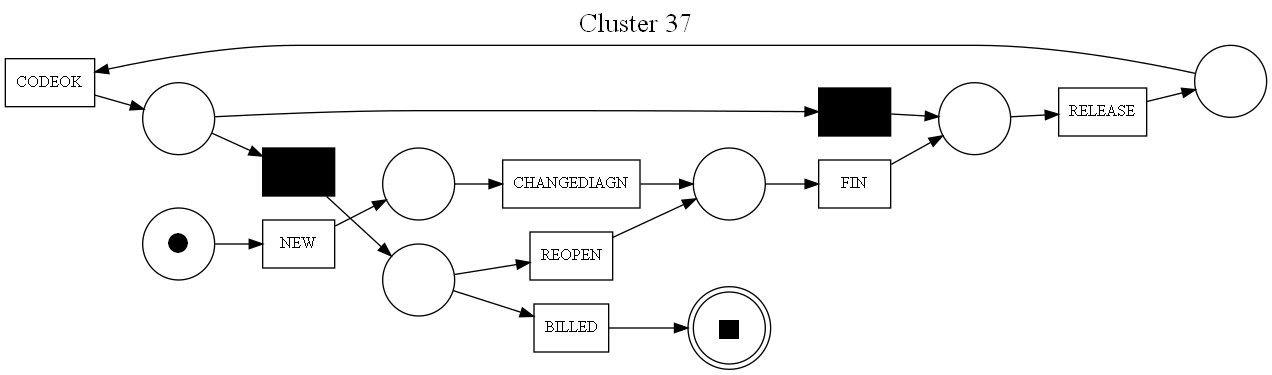

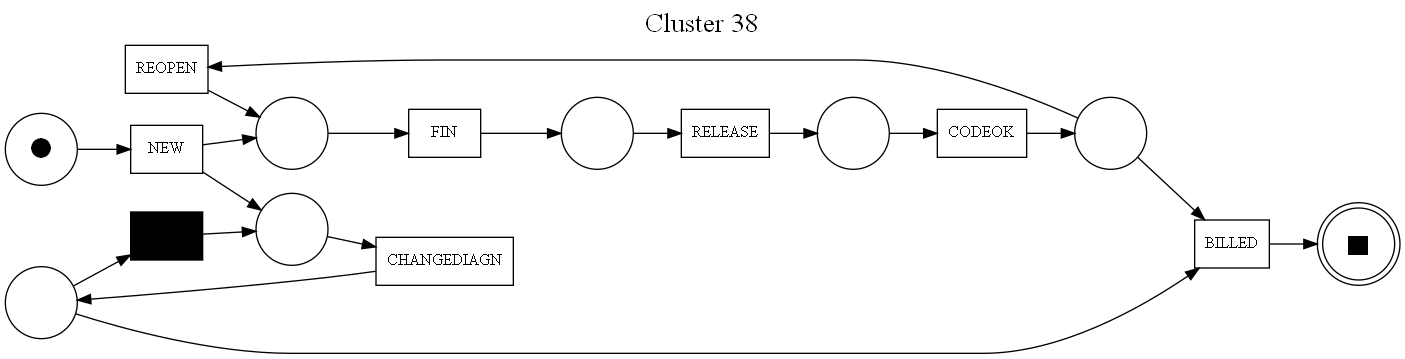

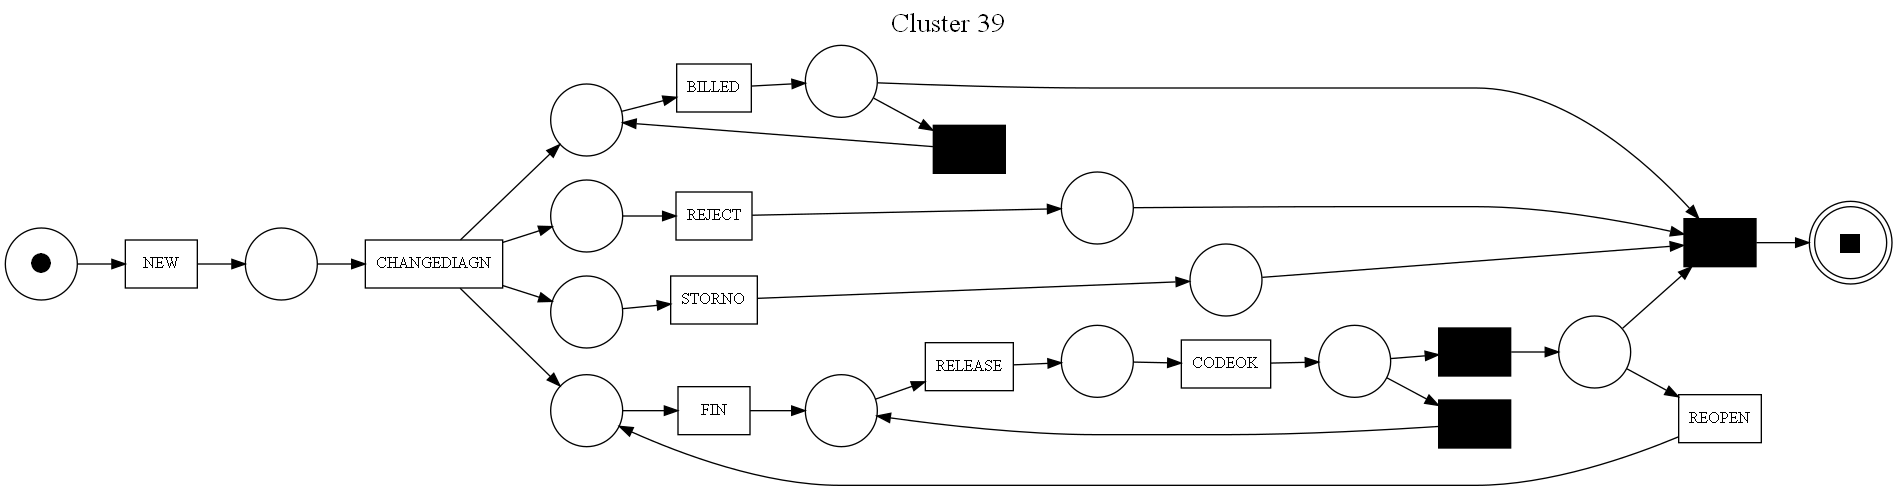

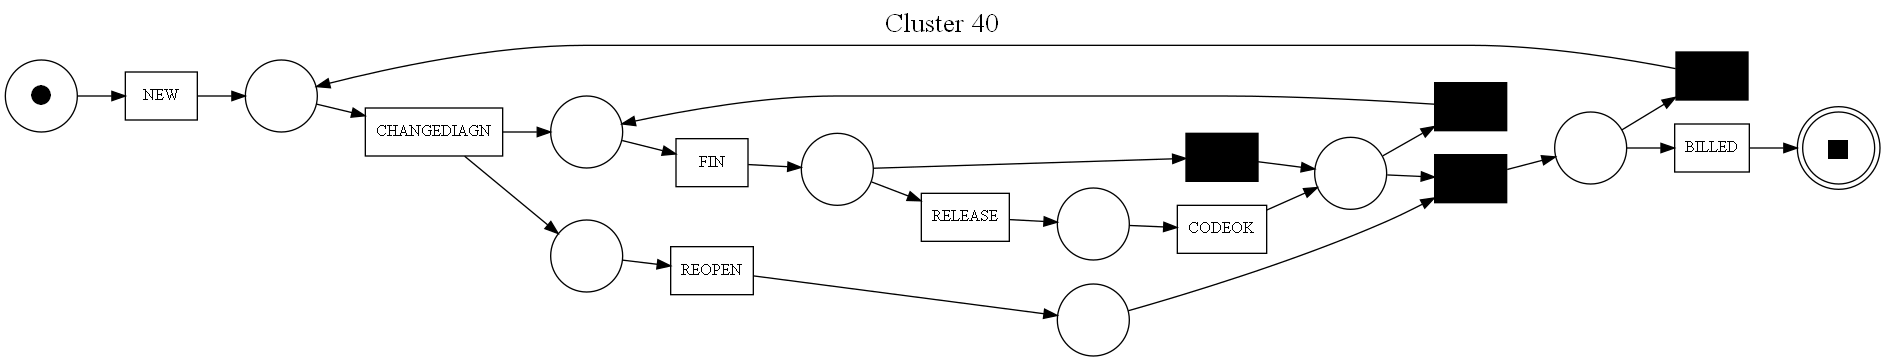

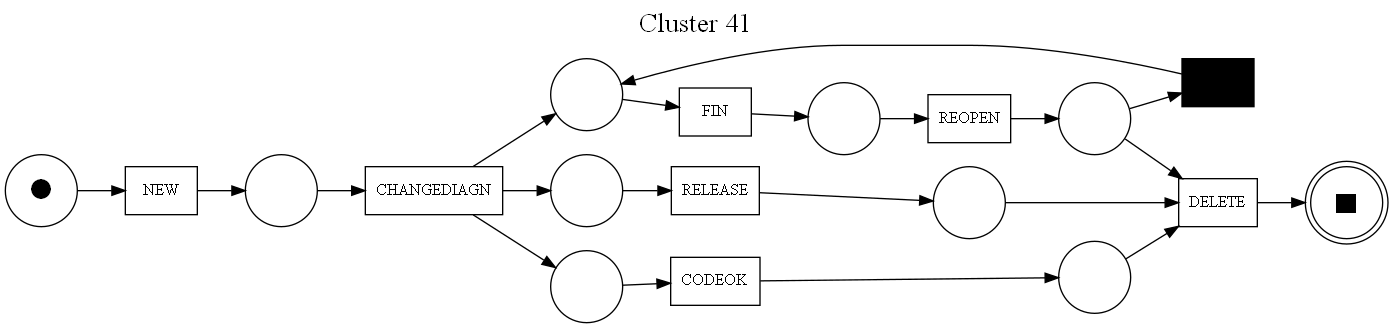

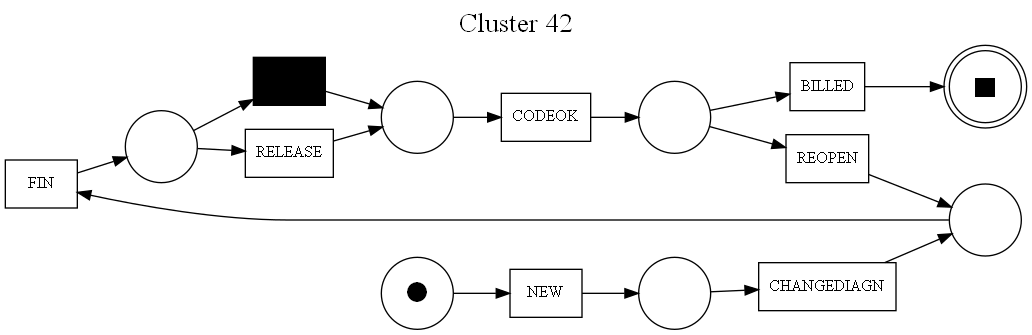

In [16]:

import pm4py
import pandas as pd
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.petri_net import visualizer as pm4pyvis

def create_event_log(traces):
    log = EventLog()
    if type(traces[0])== str:
        
        traces = list(map(eval, traces))
        
    for trace_tuple in traces:
        trace = Trace()
        for event_name in trace_tuple:
            event = Event({"concept:name": event_name})
            trace.append(event)
        log.append(trace)
    return log

df_sorted['Count'] = df.groupby('Traces')['Traces'].transform('count')

clusters = df_sorted


drop_list = ["case:concept:name", "time:timestamp"]
thisFilter = clusters.filter(drop_list)
clusters.drop(columns=thisFilter, inplace=True, axis=1)

clusters = df_sorted.groupby('Cluster')
for cluster_id, group in clusters:
    traces = group['Traces'].repeat(group['Count']).tolist()
    
    event_log = create_event_log(traces)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    gviz = pm4pyvis.apply(net, initial_marking, final_marking)
    gviz.graph_attr['label'] = f'Cluster {cluster_id}'
    gviz.graph_attr['labelloc'] = 't'
    gviz.graph_attr['fontsize'] = '20'
    pm4pyvis.view(gviz)


Tri-gram Interpretation and Visualization:

In [17]:
from sklearn.cluster import DBSCAN
import numpy as np





for eps in [0.05]:  #[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]    
   
    

    dbscan = DBSCAN(eps=eps, n_jobs=-1, min_samples=2)
    
    
    labels= dbscan.fit_predict(tri_gram)
  
    df['Cluster'] = dbscan.labels_
    df_sorted = df.sort_values(by='Cluster')

   
    cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
    
    for cluster_id, size in cluster_sizes.items():
        print(f"Cluster {cluster_id}: {size} Traces")


    df_sorted.to_csv('small_testing.csv', index=False)


Cluster -1: 975 Traces
Cluster 0: 7 Traces
Cluster 1: 2 Traces
Cluster 2: 2 Traces
Cluster 3: 2 Traces
Cluster 4: 2 Traces
Cluster 5: 2 Traces
Cluster 6: 2 Traces
Cluster 7: 2 Traces
Cluster 8: 2 Traces
Cluster 9: 2 Traces
Cluster 10: 2 Traces
Cluster 11: 2 Traces
Cluster 12: 2 Traces
Cluster 13: 2 Traces
Cluster 14: 2 Traces
Cluster 15: 2 Traces
Cluster 16: 2 Traces
Cluster 17: 2 Traces
Cluster 18: 2 Traces
Cluster 19: 2 Traces


Tri-gram Petri Nets

c:\Python312\Lib\site-packages\pm4py\utils.py:536: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


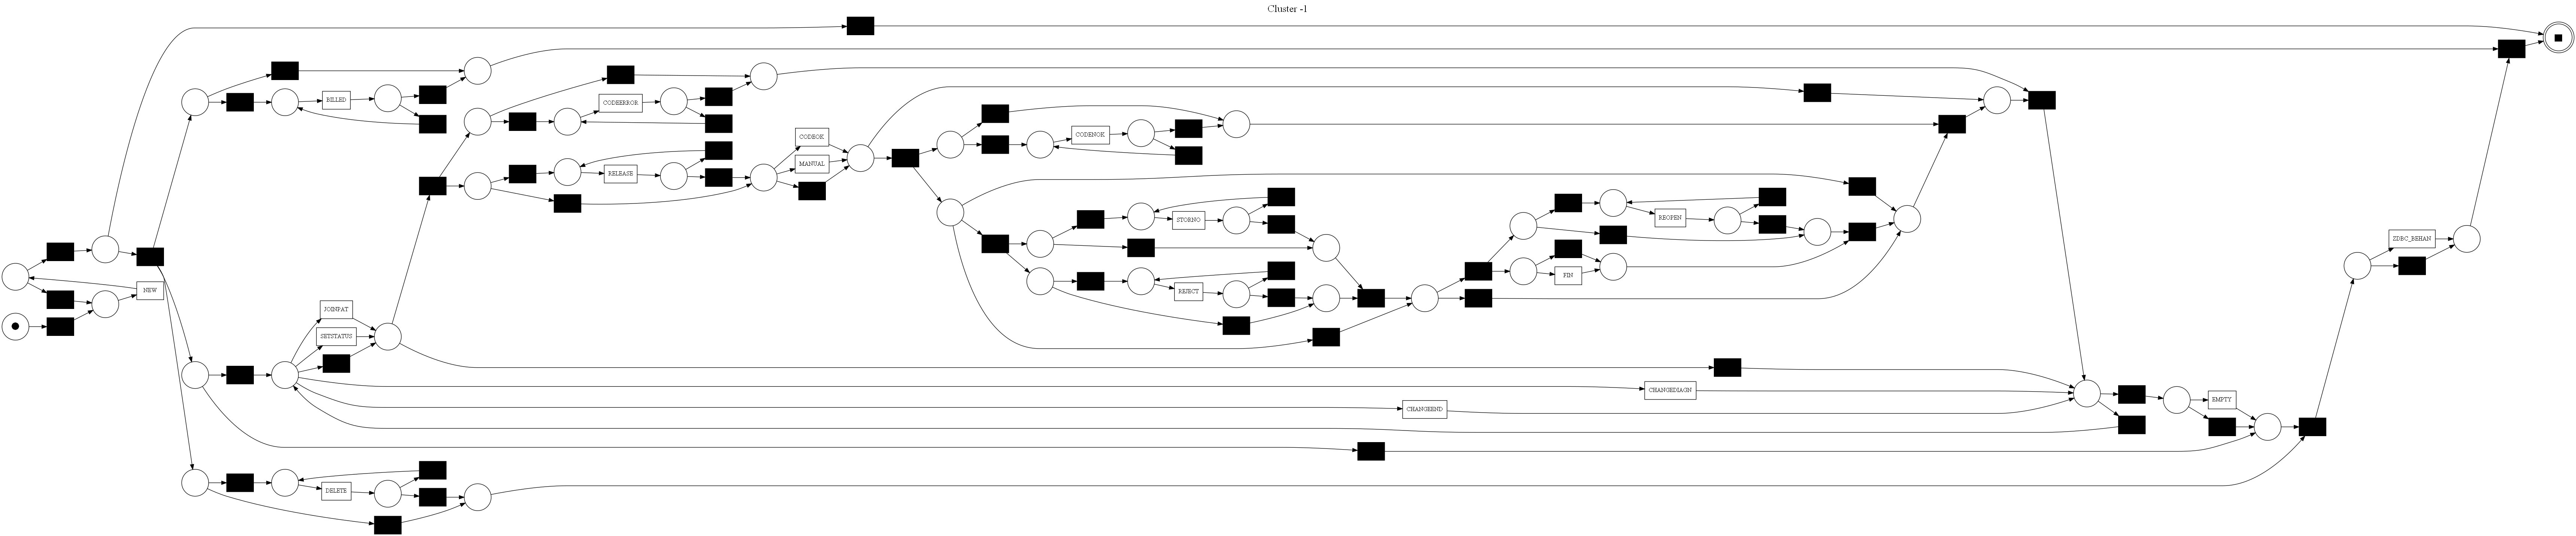

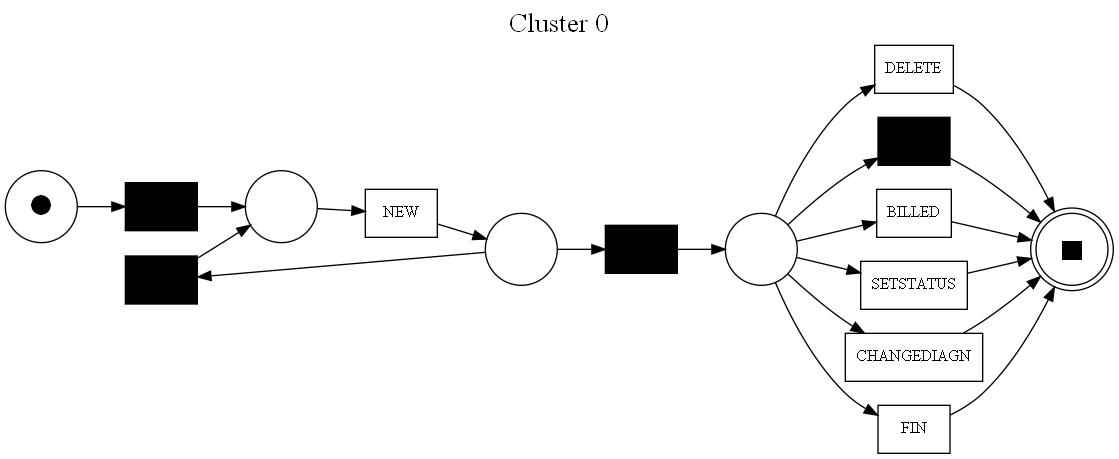

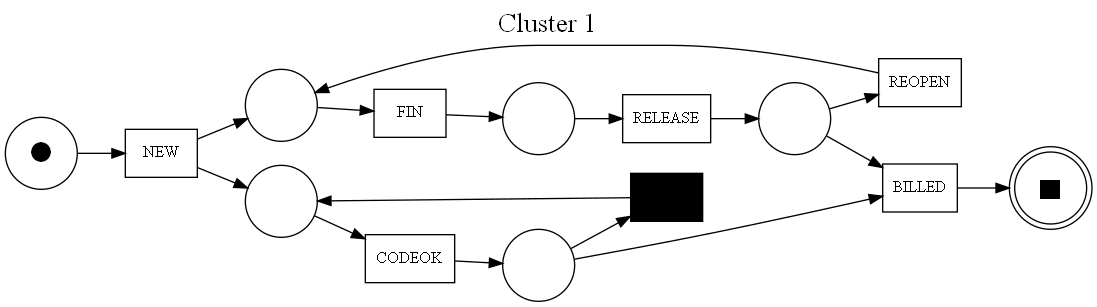

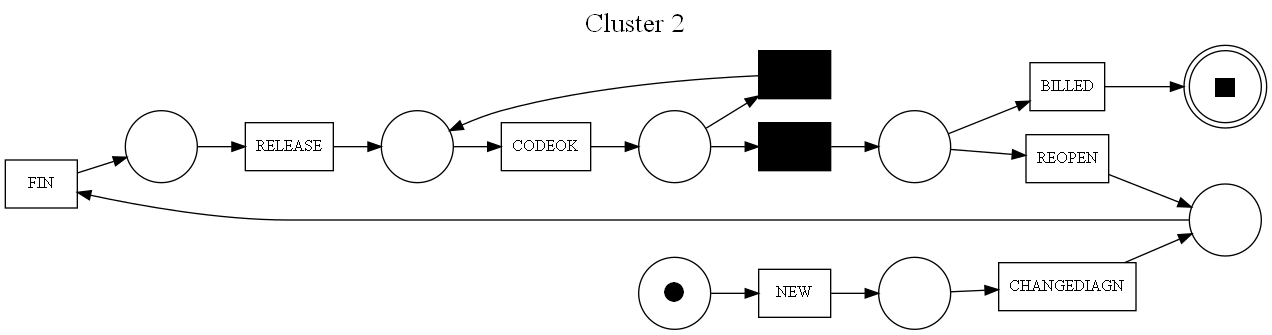

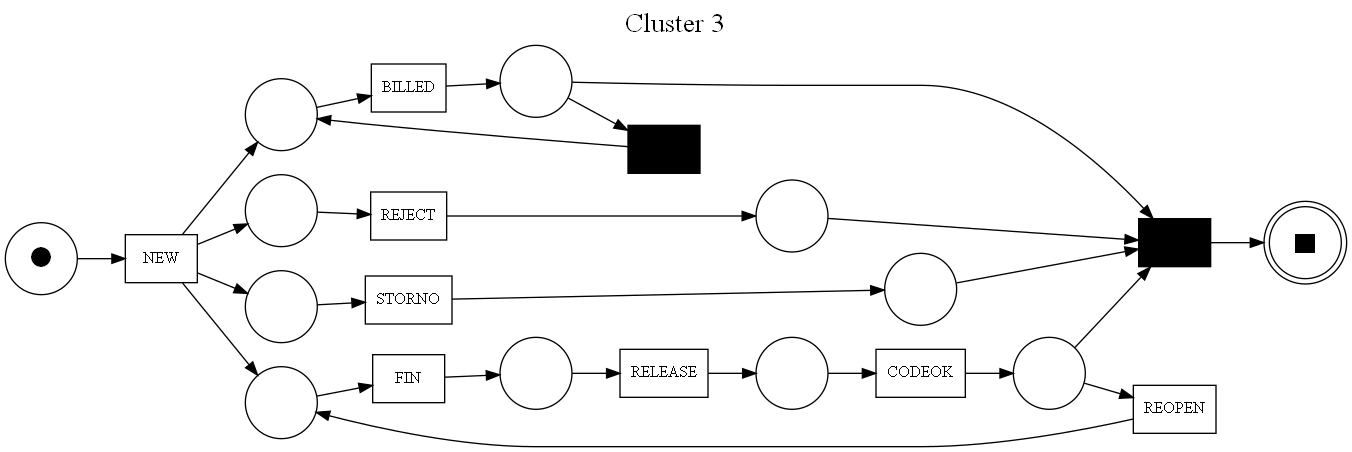

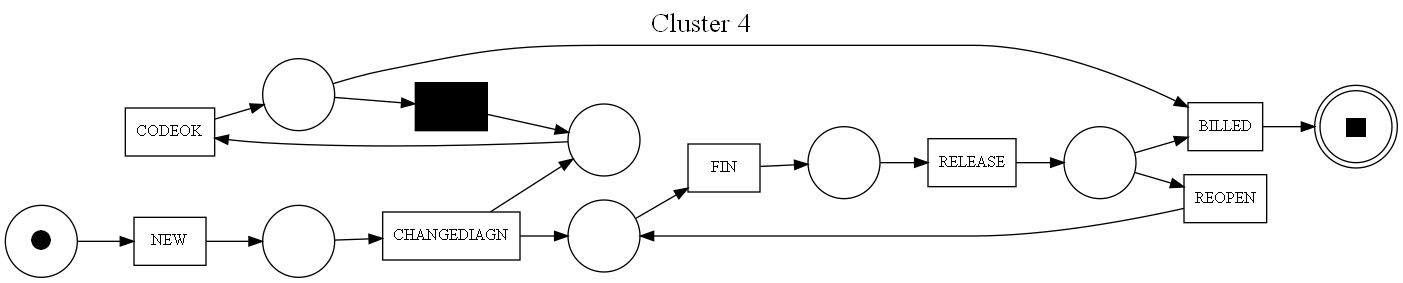

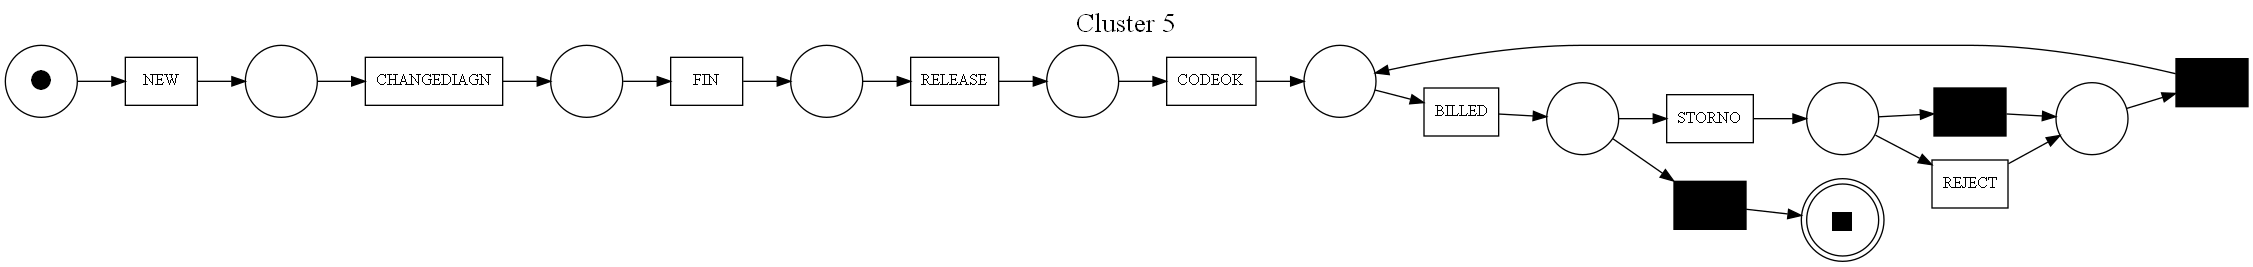

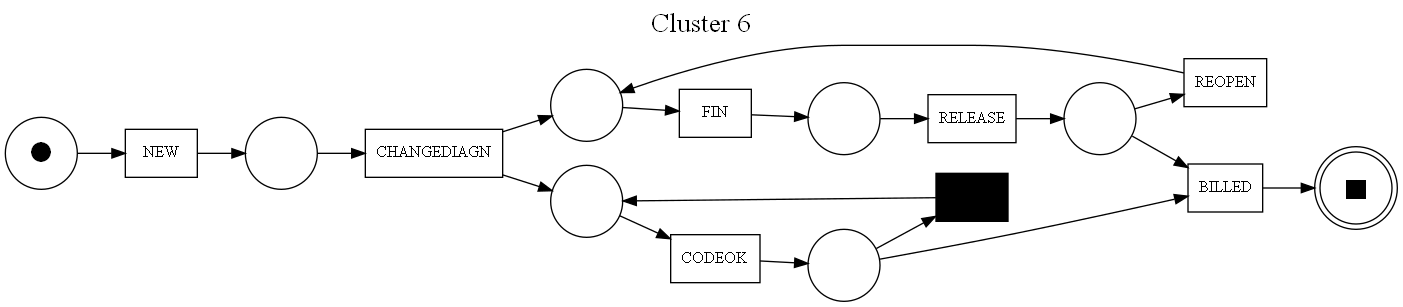

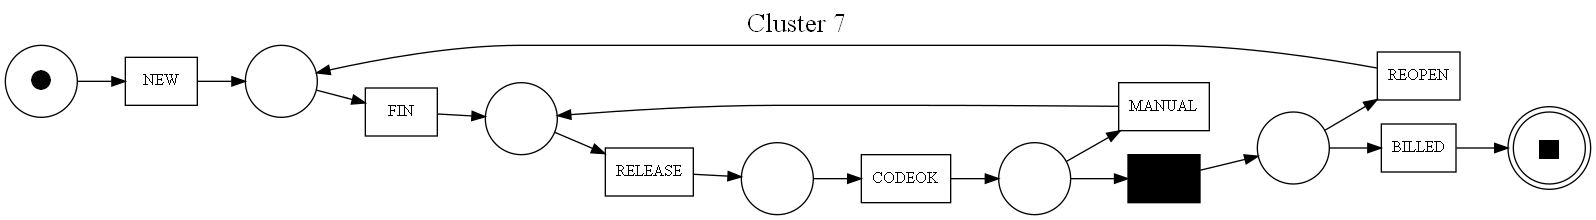

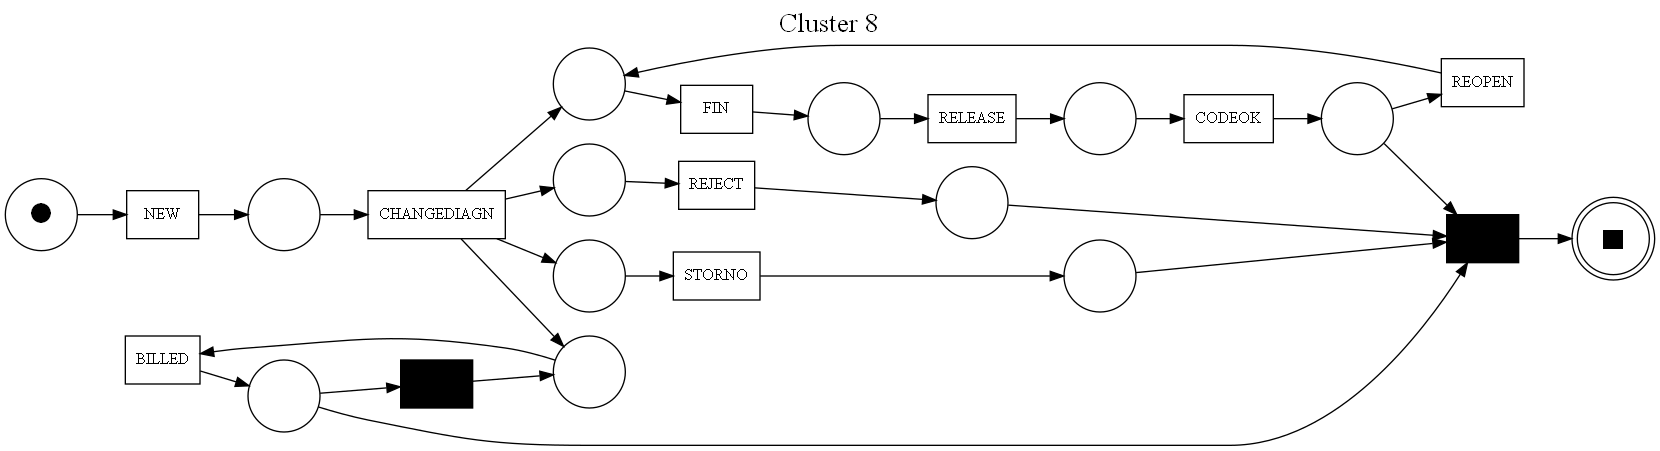

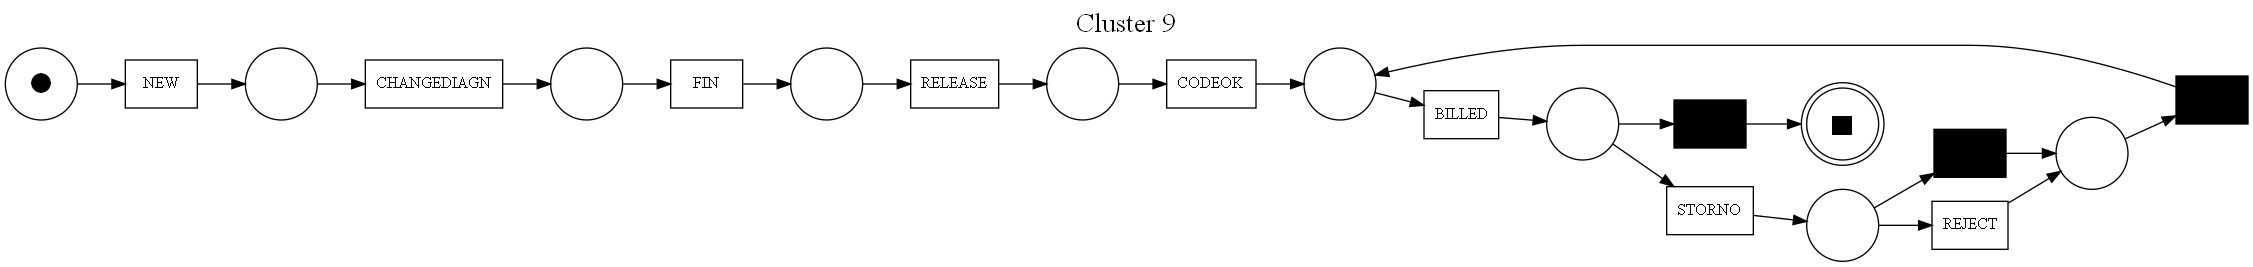

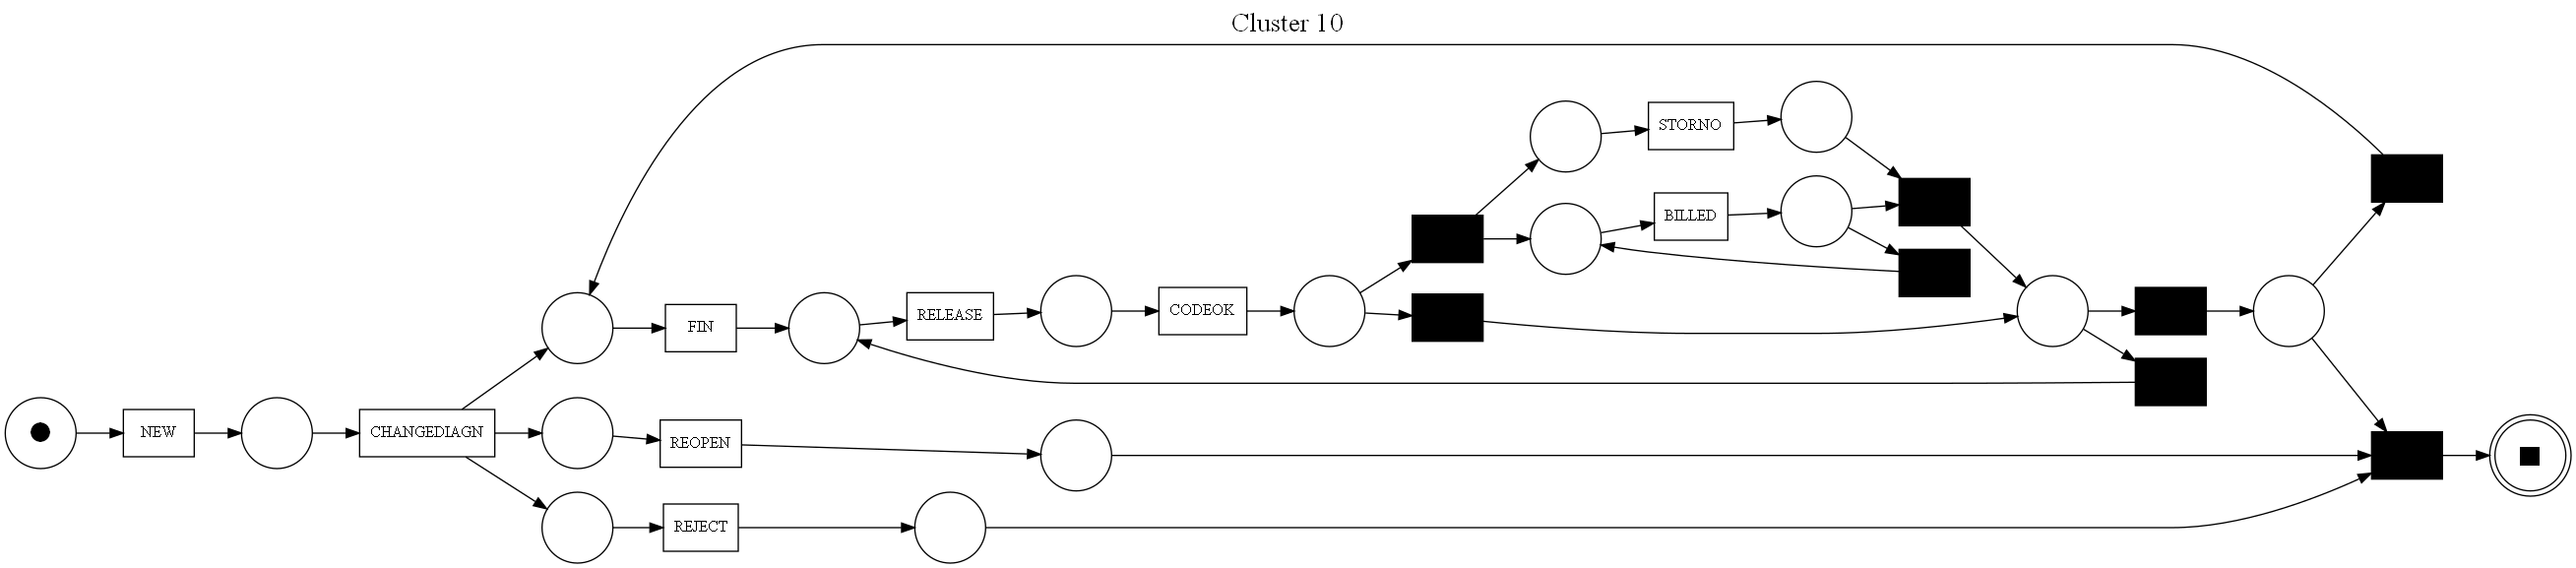

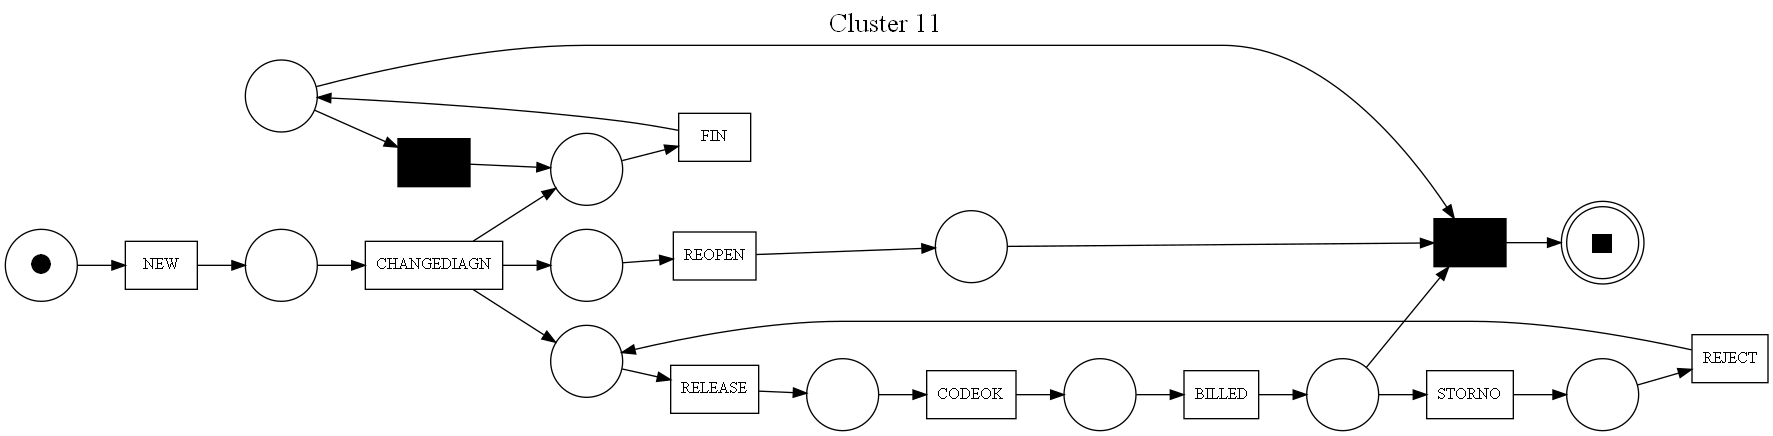

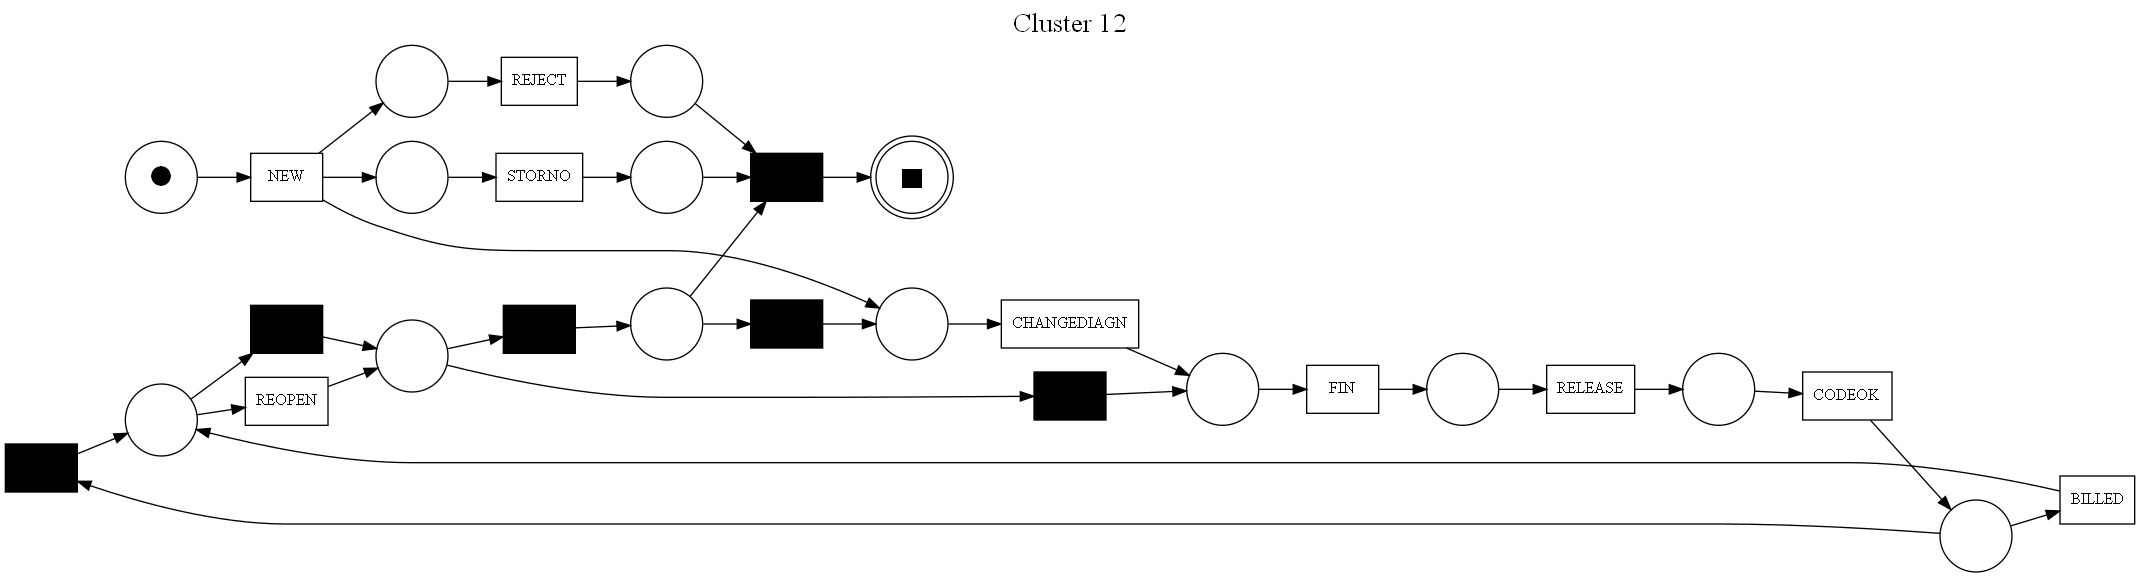

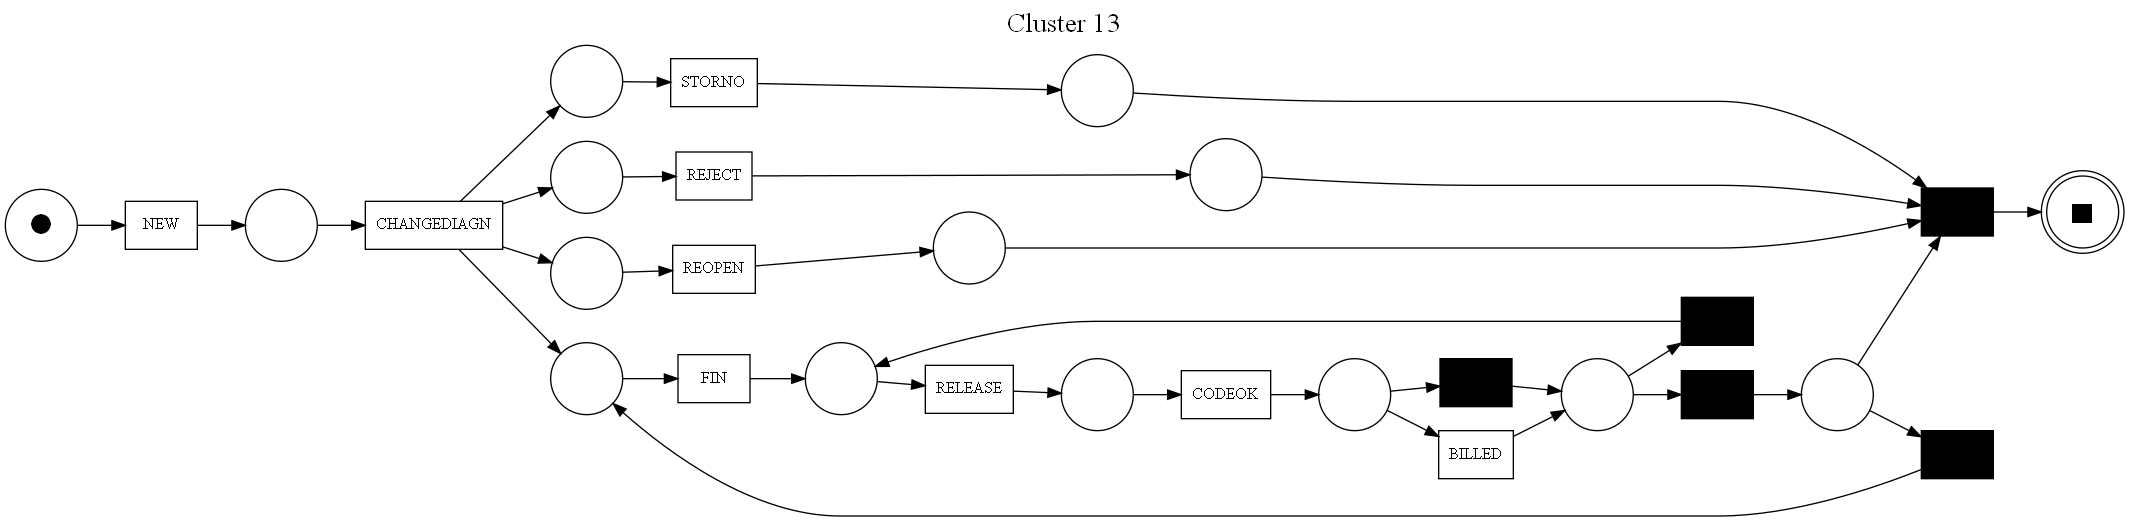

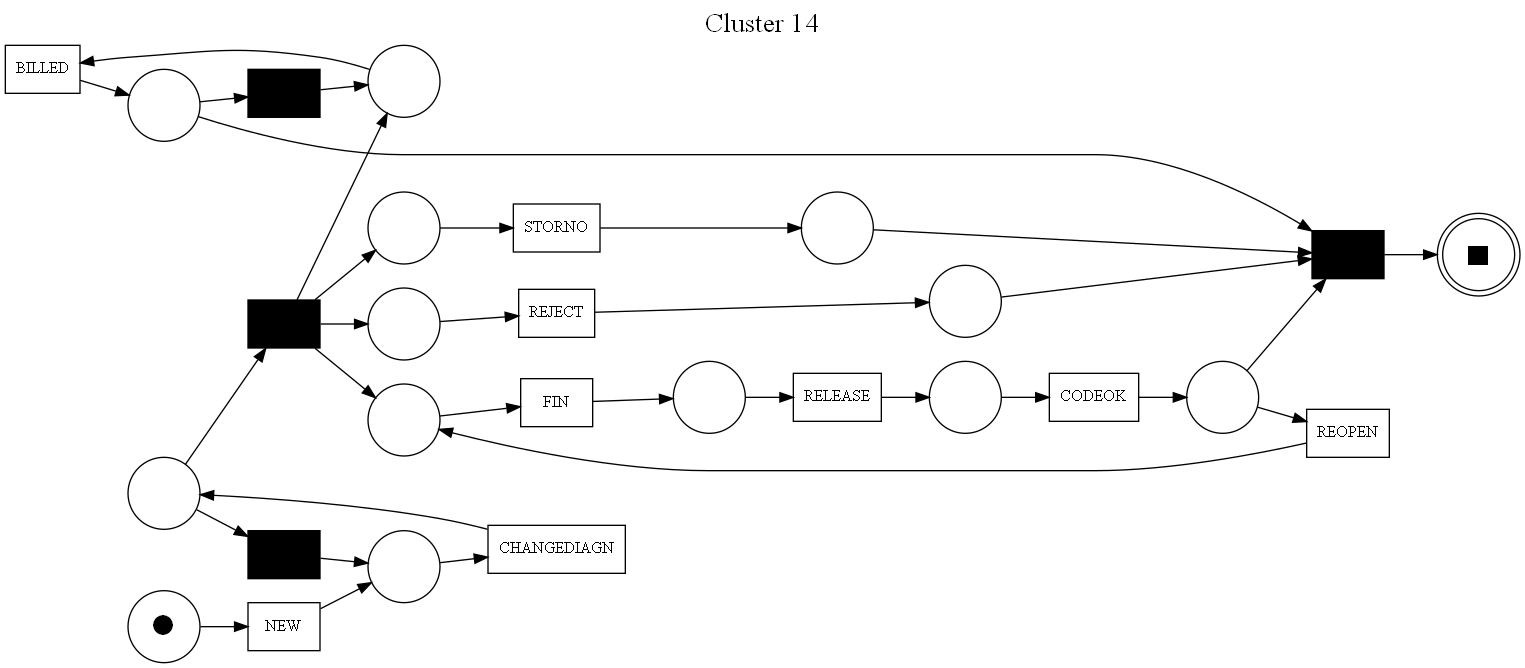

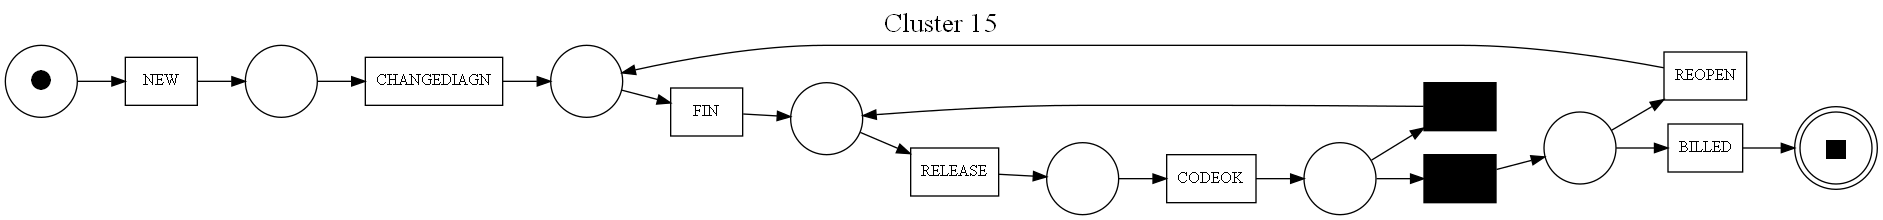

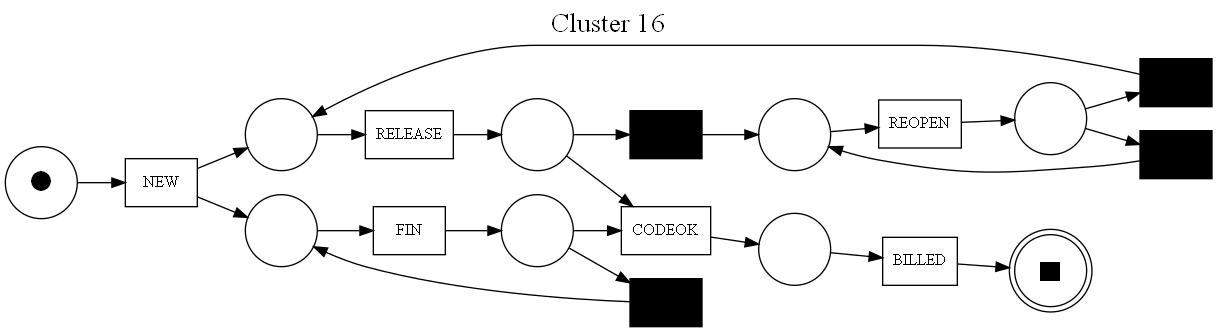

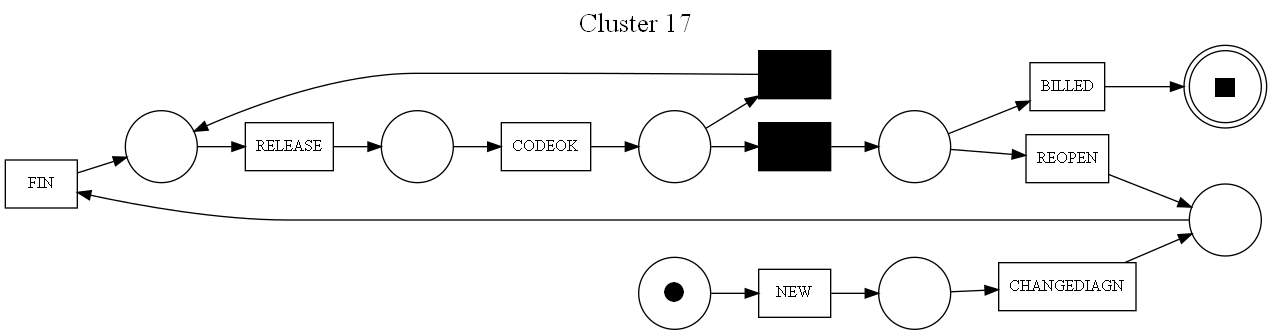

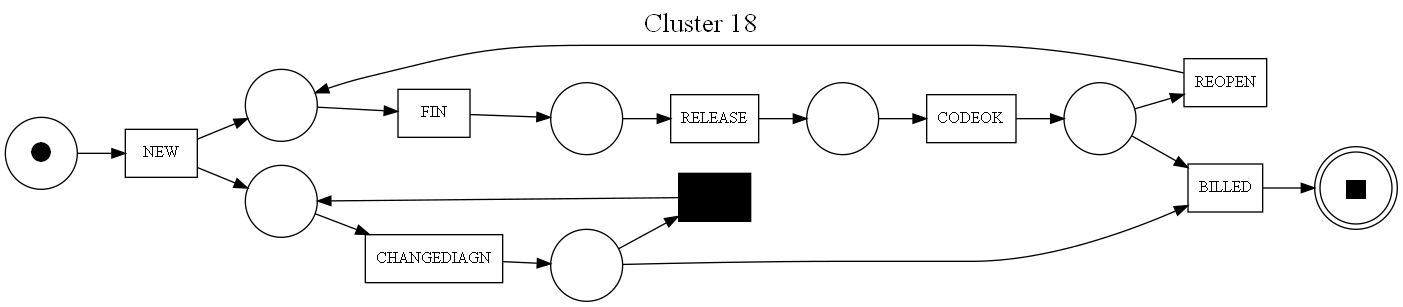

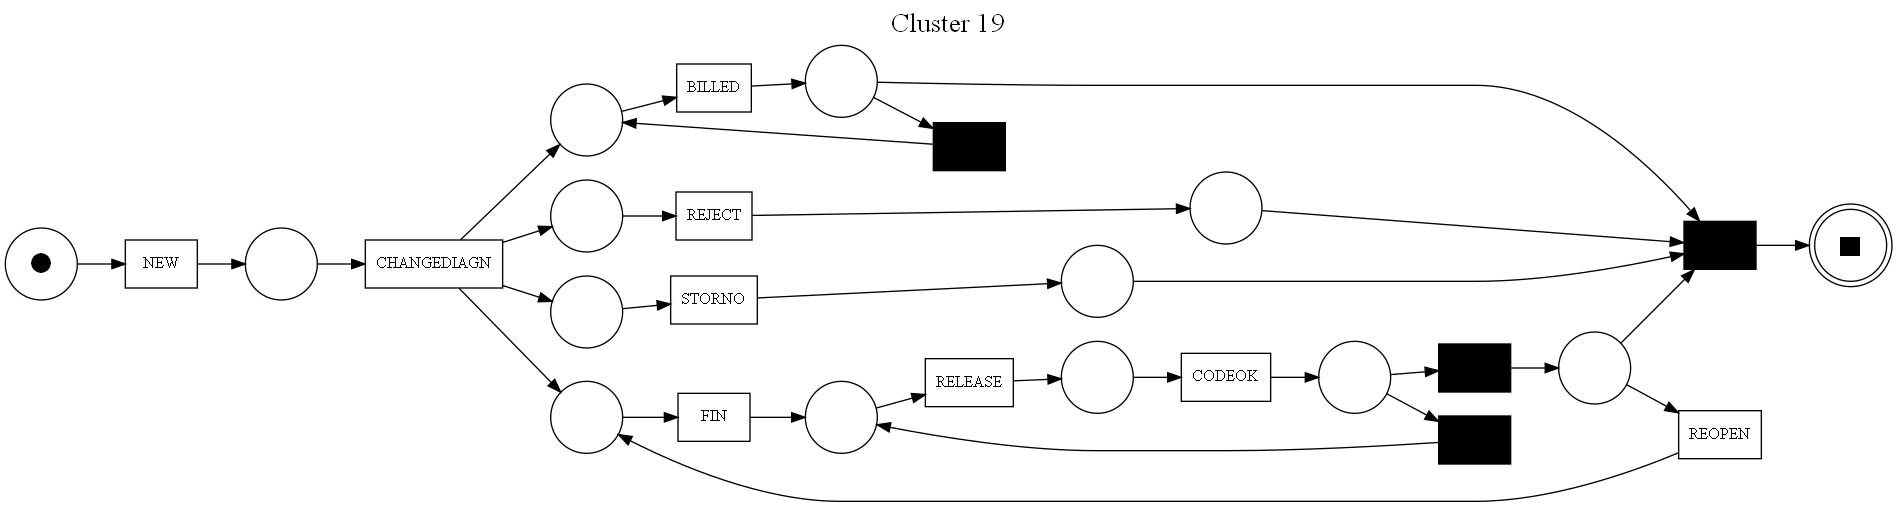

In [18]:

import pm4py
import pandas as pd
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.petri_net import visualizer as pm4pyvis

def create_event_log(traces):
    log = EventLog()
    if type(traces[0])== str:
        
        traces = list(map(eval, traces))
        
    for trace_tuple in traces:
        trace = Trace()
        for event_name in trace_tuple:
            event = Event({"concept:name": event_name})
            trace.append(event)
        log.append(trace)
    return log

df_sorted['Count'] = df.groupby('Traces')['Traces'].transform('count')

clusters = df_sorted


drop_list = ["case:concept:name", "time:timestamp"]
thisFilter = clusters.filter(drop_list)
clusters.drop(columns=thisFilter, inplace=True, axis=1)

clusters = df_sorted.groupby('Cluster')
for cluster_id, group in clusters:
    traces = group['Traces'].repeat(group['Count']).tolist()
    
    event_log = create_event_log(traces)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    gviz = pm4pyvis.apply(net, initial_marking, final_marking)
    gviz.graph_attr['label'] = f'Cluster {cluster_id}'
    gviz.graph_attr['labelloc'] = 't'
    gviz.graph_attr['fontsize'] = '20'
    pm4pyvis.view(gviz)


Silhouette Coefficient AVG: -0.4050471953645745
Silhouette Coefficient for cluster 0: 1.0
Silhouette Coefficient for cluster 1: 1.0
Silhouette Coefficient for cluster 2: 1.0
Silhouette Coefficient for cluster 3: 1.0
Silhouette Coefficient for cluster 4: 1.0
Silhouette Coefficient for cluster 5: 1.0
Silhouette Coefficient for cluster 6: 1.0
Silhouette Coefficient for cluster 7: 1.0
Silhouette Coefficient for cluster 8: 1.0
Silhouette Coefficient for cluster 9: 1.0
Silhouette Coefficient for cluster 10: 1.0
Silhouette Coefficient for cluster 11: 1.0
Silhouette Coefficient for cluster 12: 1.0
Silhouette Coefficient for cluster 13: 1.0
Silhouette Coefficient for cluster 14: 1.0
Silhouette Coefficient for cluster 15: 1.0
Silhouette Coefficient for cluster 16: 1.0
Silhouette Coefficient for cluster 17: 1.0
Silhouette Coefficient for cluster 18: 1.0
Silhouette Coefficient for cluster 19: 1.0


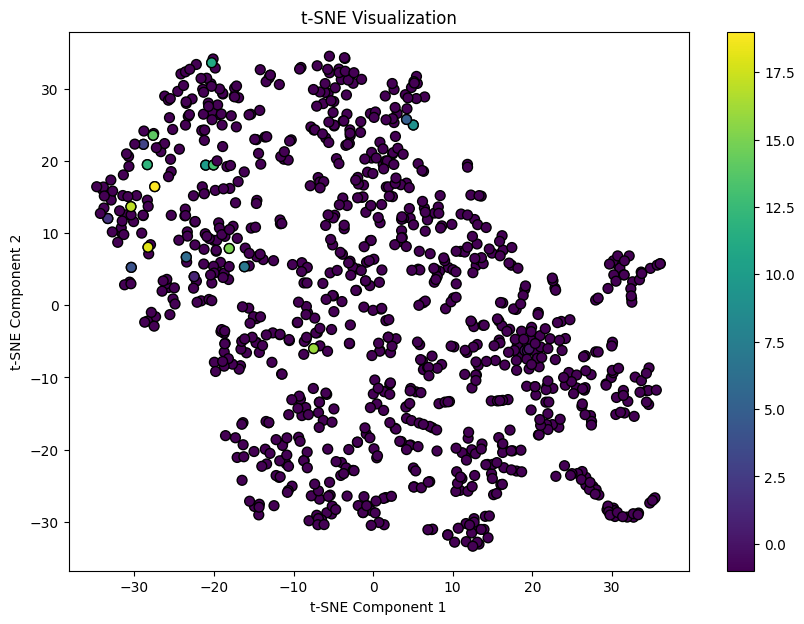

In [19]:
from sklearn.metrics import silhouette_score,silhouette_samples

if len(set(dbscan.labels_)) > 1:  
    silhouette_avg = silhouette_score(tri_gram, dbscan.labels_)
    print(f"Silhouette Coefficient AVG: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(tri_gram, dbscan.labels_)
    for i in range(len(set(dbscan.labels_)) - 1):  
        ith_cluster_silhouette_values = sample_silhouette_values[dbscan.labels_ == i]
        print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")
else:
    print("Only one cluster found. No Silhouette Coefficient.")




from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=30, n_iter=700)
tsne_result = tsne.fit_transform(tri_gram)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=dbscan.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

